In [1]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import sys
import re
import datetime
import time
import glob
import json
from tqdm import tqdm_notebook
from colorama import Fore, Style

from dotenv import load_dotenv
load_dotenv('../../.env')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    file = '../../results/figures/{}.png'.format(name)
    print('Saving figure to file {}'.format(file))
    plt.savefig(file, bbox_inches='tight', dpi=300)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.16.3
Wed Jun 19 11:02:35 2019 PDT

# Onsite Search
Alex's development notebook for onsite search.

## Load Data

### Load from the GA API v4

In [2]:
from apiclient.discovery import build
from oauth2client.client import OAuth2WebServerFlow

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = os.environ.get('GOOGLE_SERVICE_ACCOUNT_CREDENTIALS_2')
VIEW_ID = os.environ.get('GOOGLE_ANALYTICS_VIEW_ID_2')

In [64]:
from typing import Tuple

class GoogleAnalyticsApi:
    def __init__(self, raise_errors=False):
        self.raise_errors = raise_errors
        self.api = self.initialize_api()

    def initialize_api(self):
        flow = OAuth2WebServerFlow(
            client_id=self.client_id,
            client_secret=self.client_secret,
            scope='https://www.googleapis.com/auth/analytics.readonly',
            redirect_uri='urn:ietf:wg:oauth:2.0:oob'
        )
        authorize_url = flow.step1_get_authorize_url()
        print('Receive code from:\n{}\n'.format(authorize_url))
        code = input('Enter code here: ').strip()
        credentials = flow.step2_exchange(code)
        
        api = build('analyticsreporting', 'v4', credentials=credentials)
        return api

    @property
    def client_id(self):
        try:
            with open(KEY_FILE_LOCATION, 'r') as f:
                return json.load(f)['client_id']
        except:
            sys.exit('Unable to load client_id from file {}'
                      .format(KEY_FILE_LOCATION))
            return ''
        
    @property
    def client_secret(self):
        try:
            with open(KEY_FILE_LOCATION, 'r') as f:
                return json.load(f)['client_secret']
        except:
            sys.exit('Unable to load client_secret from file {}'
                      .format(KEY_FILE_LOCATION))
            return ''

    def query_onsite_search(
        self,
        start_date,
        end_date, 
        api_delay=3,
        verbose=False,
        test=False,
        raise_errors=False,
    ) -> pd.DataFrame:
        """
        Make API request for on-site search data, grouped by day.
        
        start_date : str
            ISO formatted start date.
            
        end_date : str
            ISO formatted end date.
            
        api_delay : int
            Delay in between requests in seconds. Multiple requests
            will be made due to pagination.
        """
        dfs = []
        page_token = None
        while True:
            print('Making API request with page_token = {}'.format(page_token))
            df_, page_token = self.query_onsite_search_page(
                start_date,
                end_date,
                page_token,
                verbose,
                raise_errors,
            )
            dfs.append(df_)
            if ((len(df_) == 0) or (page_token is None)):
                break
            if verbose:
                print('Waiting for {} seconds'.format(api_delay))
            time.sleep(api_delay)
            
            if test:
                print('Testing mode - exiting API call loop')
                break
        
        return pd.concat(dfs, sort=False, ignore_index=True)

        
    def query_onsite_search_page(
        self,
        start_date,
        end_date,
        page_token,
        verbose,
        raise_errors,
    ) -> Tuple[pd.DataFrame, int]: 
        body = {
            "reportRequests": [{
                "viewId": VIEW_ID,
                "pageSize": "1000",                
                "dateRanges": [{
                  "startDate": start_date,
                  "endDate": end_date,
                }],
                "metrics": [{
                    "expression": "ga:searchUniques",
                }],
                "dimensions": [
                {
                    "name": "ga:date",
                },
                {
                    "name": "ga:searchKeyword",
                }]
            }]
        }
        if page_token is not None:
            body['reportRequests'][0]['pageToken'] = page_token
        
        try:
            if verbose:
                print('Making api request:\n{}'.format(json.dumps(body, indent=2)))
            response = self.api.reports().batchGet(body=body).execute()
        except Exception as e:
            print('Unable to execute API call. See debug info below.')
            print('date_start = {}'.format(start_date))
            print('date_end = {}'.format(end_date))
            print('error = {}'.format(e))
            if self.raise_errors:
                raise e
            else:
                return pd.DataFrame(), None

        try:
            print('Parsing response')
            df = self.parse_onsite_search_resp(response)
            next_page_token = self.parse_next_page_token(response)
        except Exception as e:
            print('Unable to parse API response. See debug info below.')
            print('date_start = {}'.format(start_date))
            print('date_end = {}'.format(end_date))
            print('response = {}'.format(response))
            print('error = {}'.format(e))
            if self.raise_errors or raise_errors:
                raise e
            else:
                return pd.DataFrame(), None
            
        return df, next_page_token

    @staticmethod
    def parse_next_page_token(response) -> pd.DataFrame:
        return response.get('reports', [{}])[0].get('nextPageToken', None)
    
    @staticmethod
    def parse_onsite_search_resp(response) -> pd.DataFrame:
        cols = ['date', 'search_term', 'num_searches']
        
        rows = response.get('reports', [{}])[0].get('data', {}).get('rows', [])
        data = []
        for i, row in enumerate(rows):
            d = []

            dims = row.get('dimensions', [])
            if len(dims) == 2:
                d += dims
            else:
                raise Exception('Warning, response parse failed as len(dim) != 2 for row = {} (#{})'.format(row, i))

            vals = row.get('metrics', [{}])[0].get('values', [])
            if len(vals) == 1:
                d += vals
            else:
                raise Exception('Warning, response parse failed as len(vals) != 1 for row = {} (#{})'.format(row, i))

            data.append(d)

        if len(data) == 0:
            print('Parsed 0 rows from API response')
            return pd.DataFrame(columns=cols)
        
        df = pd.DataFrame(data, columns=cols)
        try:
            df.date = pd.to_datetime(df.date)
        except:
            print('Warning, unable to parse date.\ndf.head() =\n{}'.format(df.head()))
            print('Attempting to parse with method `coerce` and dropping NaTs')
            len_0 = len(df)
            df.date = pd.to_datetime(df.date, errors='coerce')
            m_drop = df.date.isnull()
            df = df.loc[~m_drop]
            num_dropped = len_0 - len(df)
            print('Dropped {:,.0f} rows ({:.1f}%)'.format(num_dropped, num_dropped / len(df) * 100))

        df.num_searches = df.num_searches.astype(int)
        print('Parsed {} rows from API response'.format(len(df)))
        
        return df

In [ ]:
api = GoogleAnalyticsApi()

In [5]:
month_date_pairs = [('{}-01'.format(x.strftime('%Y-%m')), x.strftime('%Y-%m-%d'))
 for x in pd.date_range(start='2017-10-01', periods=20, freq='M').tolist()]
month_date_pairs

[('2017-10-01', '2017-10-31'),
 ('2017-11-01', '2017-11-30'),
 ('2017-12-01', '2017-12-31'),
 ('2018-01-01', '2018-01-31'),
 ('2018-02-01', '2018-02-28'),
 ('2018-03-01', '2018-03-31'),
 ('2018-04-01', '2018-04-30'),
 ('2018-05-01', '2018-05-31'),
 ('2018-06-01', '2018-06-30'),
 ('2018-07-01', '2018-07-31'),
 ('2018-08-01', '2018-08-31'),
 ('2018-09-01', '2018-09-30'),
 ('2018-10-01', '2018-10-31'),
 ('2018-11-01', '2018-11-30'),
 ('2018-12-01', '2018-12-31'),
 ('2019-01-01', '2019-01-31'),
 ('2019-02-01', '2019-02-28'),
 ('2019-03-01', '2019-03-31'),
 ('2019-04-01', '2019-04-30'),
 ('2019-05-01', '2019-05-31')]

Let's test it out...

In [6]:
dfs = []
i = 0
for start_date, end_date in month_date_pairs:
    i += 1
    dfs.append(api.query_onsite_search(start_date, end_date, api_delay=0, verbose=True, test=True))
    if i ==2:
        break

df_search_terms = pd.concat(dfs)

Making API request with page_token = None
Making api request:
{
  "reportRequests": [
    {
      "viewId": "150523169",
      "pageSize": "1000",
      "dateRanges": [
        {
          "startDate": "2017-10-01",
          "endDate": "2017-10-31"
        }
      ],
      "metrics": [
        {
          "expression": "ga:searchUniques"
        }
      ],
      "dimensions": [
        {
          "name": "ga:date"
        },
        {
          "name": "ga:searchKeyword"
        }
      ]
    }
  ]
}
Parsing response
Parsed 1000 rows from API response
Waiting for 0 seconds
Testing mode - exiting API call loop
Making API request with page_token = None
Making api request:
{
  "reportRequests": [
    {
      "viewId": "150523169",
      "pageSize": "1000",
      "dateRanges": [
        {
          "startDate": "2017-11-01",
          "endDate": "2017-11-30"
        }
      ],
      "metrics": [
        {
          "expression": "ga:searchUniques"
        }
      ],
      "dimensions": [

In [87]:
df_search_terms.head(15)

date                       search_term  num_searches  \
0     2017-10-01                        ,axi dress             1   
14310 2017-10-01                  ´boyfriend jeans             1   
14309 2017-10-01       'you me oui' slogan t-shirt             1   
14308 2017-10-01                              ;ace             1   
14307 2017-10-01                  ;eather trousers             1   
14306 2017-10-01                        ：05a43mwht             1   
14305 2017-10-01  .short sleeve jungle print shirt             1   
14304 2017-10-01              '1990' motif t-shirt             1   
14311 2017-10-01                                 "             1   
14303 2017-10-01                       'c'est moi'             1   
14301 2017-10-01         'have a nice day' t-shirt             1   
14300 2017-10-01                      'k' necjlace             1   
14299 2017-10-01                      'k' necklace             1   
14298 2017-10-01                            'merci             1   
14297 2017-10-01                           'merci'             1   

                      search_term_lower  
0                            ,axi dress  
14310                  ´boyfriend jeans  
14309       'you me oui' slogan t-shirt  
14308                              ;ace  
14307                  ;eather trousers  
14306                        ：05a43mwht  
14305  .short sleeve jungle print shirt  
14304              '1990' motif t-shirt  
14311                                 "  
14303                       'c'est moi'  
14301         'have a nice day' t-shirt  
14300                      'k' necjlace  
14299                      'k' necklace  
14298                            'merci  
14297                           'merci'

In [88]:
df_search_terms.tail(15)

date               search_term  num_searches  \
9697302 2019-05-30            yellow printed             1   
9697303 2019-05-30        yellow printed top             1   
9697304 2019-05-30        yellow ribbed tops             1   
9697305 2019-05-30  yellow rope belted dress             1   
9697306 2019-05-30         yellow lace dress             1   
9697307 2019-05-30            yellow sandaal             1   
9697308 2019-05-30               yellow shoe             1   
9697309 2019-05-30              yellow shoes             4   
9697310 2019-05-30              yellow shops             1   
9697311 2019-05-30             yellow shorts             1   
9697312 2019-05-30               yellow show             1   
9697313 2019-05-30              yellow skirt            12   
9697314 2019-05-30             yellow skirts             1   
9697316 2019-05-30        yellow stripe dres             1   
9694845 2019-05-30         link shoulder bag             1   

                search_term_lower  
9697302            yellow printed  
9697303        yellow printed top  
9697304        yellow ribbed tops  
9697305  yellow rope belted dress  
9697306         yellow lace dress  
9697307            yellow sandaal  
9697308               yellow shoe  
9697309              yellow shoes  
9697310              yellow shops  
9697311             yellow shorts  
9697312               yellow show  
9697313              yellow skirt  
9697314             yellow skirts  
9697316        yellow stripe dres  
9694845         link shoulder bag

Went back and added verbose flag, and sleep in between calls

Now pulling the data we want

In [58]:
from tqdm import tqdm_notebook

In [ ]:
dfs = []
for start_date, end_date in tqdm_notebook(month_date_pairs):
    dfs.append(api.query_onsite_search(start_date, end_date, api_delay=1))

df_search_terms = pd.concat(dfs)

Dump raw result data

In [82]:
os.getenv('DATA_PATH')

'/Volumes/GoogleDrive/My Drive/ga-data-mining/data'

In [87]:
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_raw')
if os.path.isfile('{}.csv'.format(f_path)) or os.path.isfile('{}.pkl'.format(f_path)):
    raise Exception('File at {} already exists. Will not overwrite.'.format(f_path))

df_search_terms.to_csv('{}.csv'.format(f_path), index=False)
df_search_terms.to_pickle('{}.pkl'.format(f_path))

### Load data from file

In [86]:
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_raw')
df_search_terms = pd.read_pickle('{}.pkl'.format(f_path))
df_search_terms['search_term_lower'] = df_search_terms.search_term.str.strip().str.lower()

In [89]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower  
0                       ,axi dress  
14310             ´boyfriend jeans  
14309  'you me oui' slogan t-shirt  
14308                         ;ace  
14307             ;eather trousers

In [90]:
len(df_search_terms)

10707497

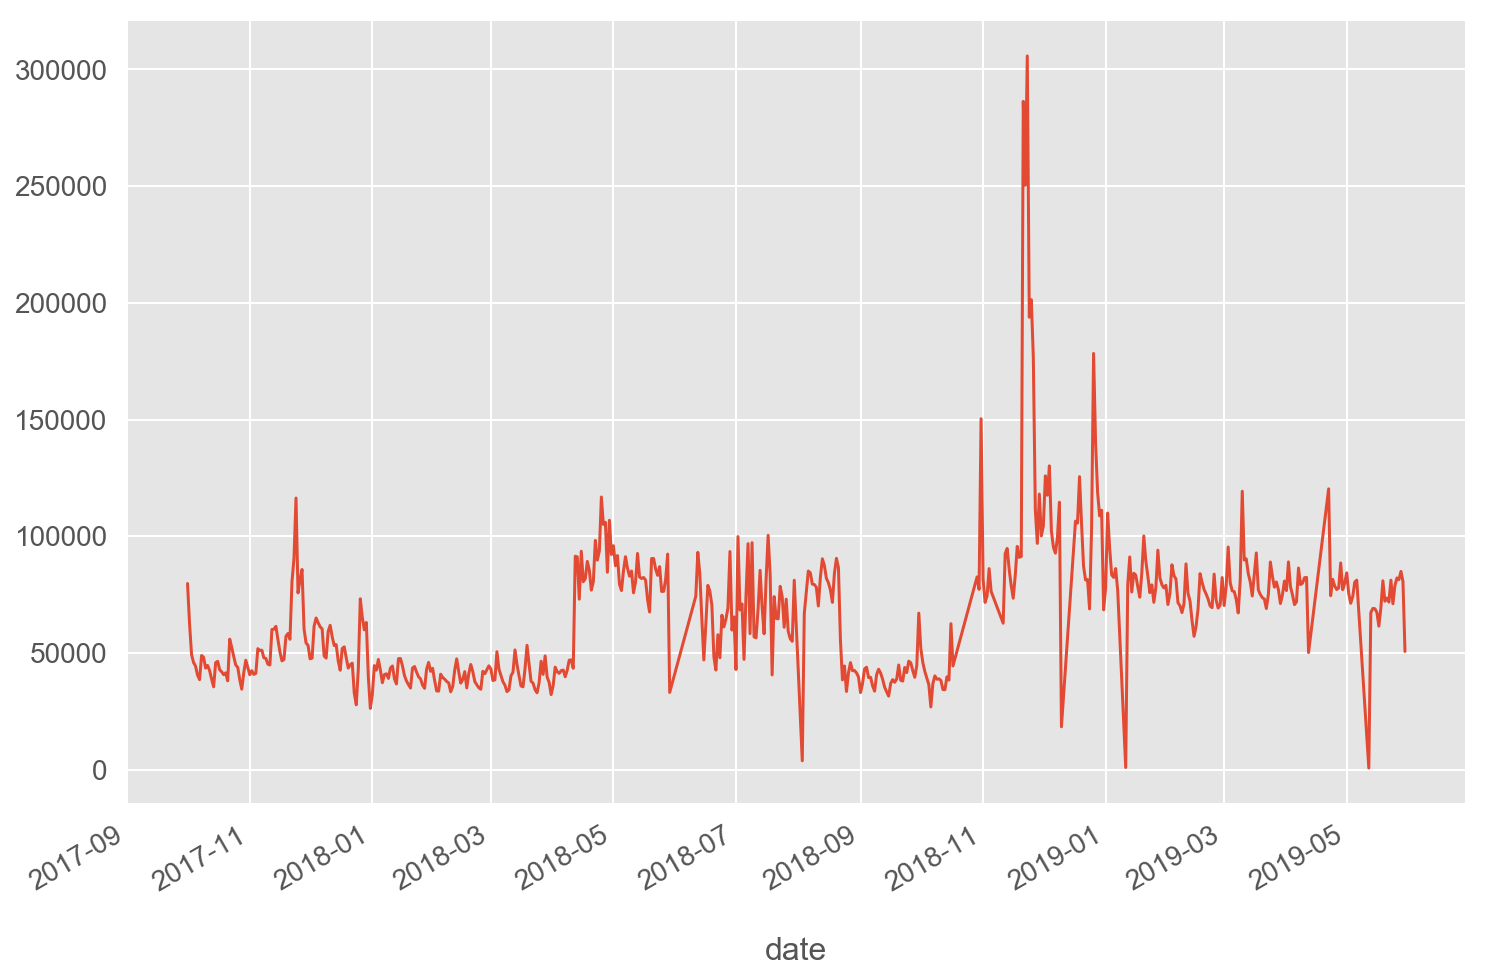

In [93]:
df_search_terms.groupby('date').num_searches.sum().plot()

We were able to pull over 10M onsite searches!

## Data Modeling

### Wordclouds

In [28]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [17]:
WordCloud?

In [29]:
def make_wordcloud(data, title=None, colormap='cividis'):
    """
    Generate a wordcloud.
    
    data : dict
        Term frequencies.
    """
    wordcloud = WordCloud(
        background_color='white',
        colormap=colormap,
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=80,
        scale=10,
        width=800,
        height=400,
        random_state=19, # just used to set color I think
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title is not None:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    return fig

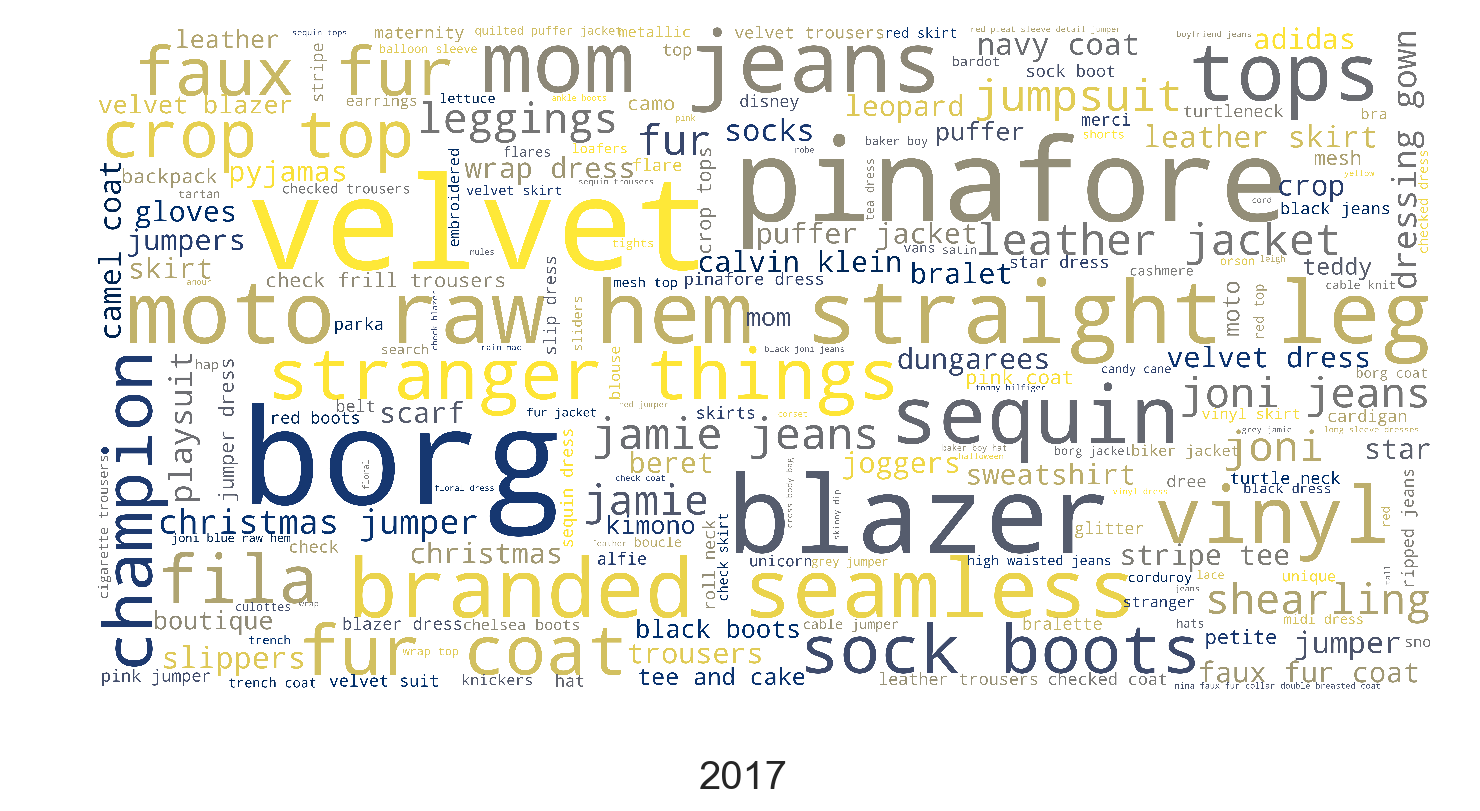

In [42]:
m = df_search_terms.date.apply(lambda x: x.strftime('%Y')) == '2017'
term_counts = df_search_terms[m].groupby('search_term_lower').num_searches.sum()
fig = make_wordcloud(term_counts.to_dict(), '2017')
savefig('onsite_search_tag_cloud_2017')
plt.show()

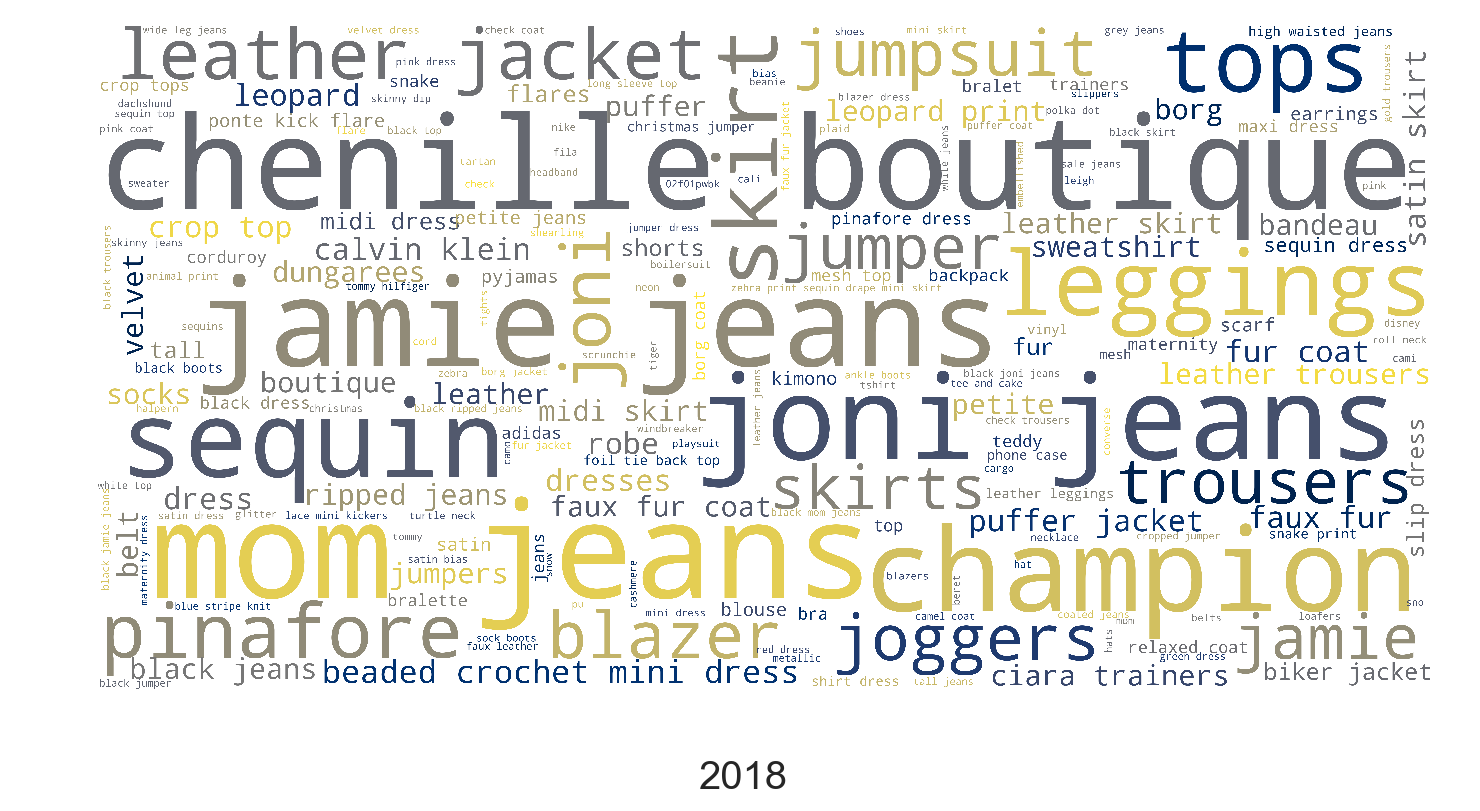

In [43]:
m = df_search_terms.date.apply(lambda x: x.strftime('%Y')) == '2018'
term_counts = df_search_terms[m].set_index('search_term').num_searches
fig = make_wordcloud(term_counts.to_dict(), '2018')
savefig('onsite_search_tag_cloud_2018')
plt.show()

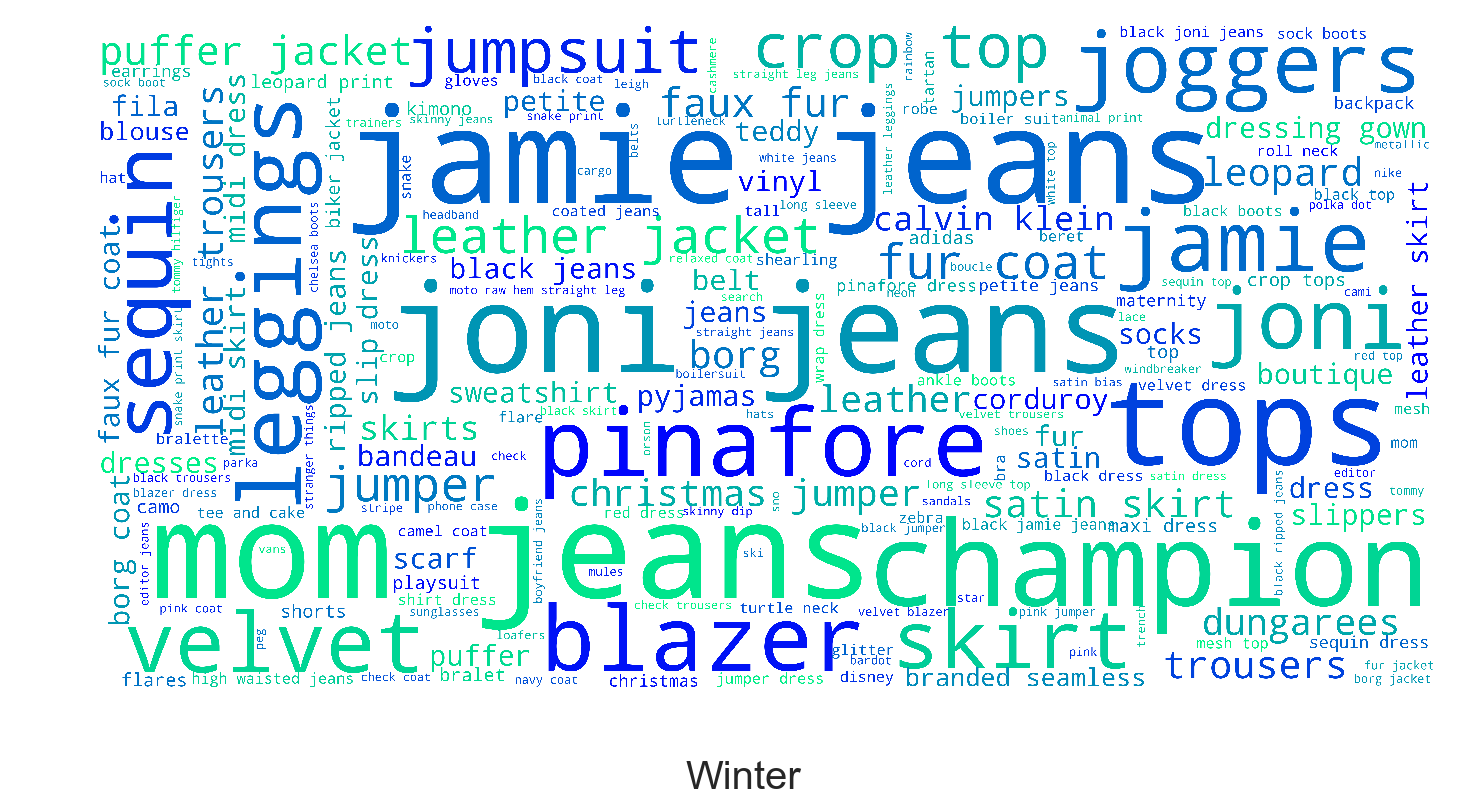

In [44]:
s = df_search_terms.date.apply(lambda x: x.month)
# Filter on Nov - Feb
m = ((s >= 11) & (s <= 12)) | ((s >= 1) & (s <= 2))
winter_term_counts = df_search_terms[m].groupby('search_term_lower').num_searches.sum()
fig = make_wordcloud(winter_term_counts.to_dict(), 'Winter', colormap='winter')
savefig('onsite_search_tag_cloud_winter')

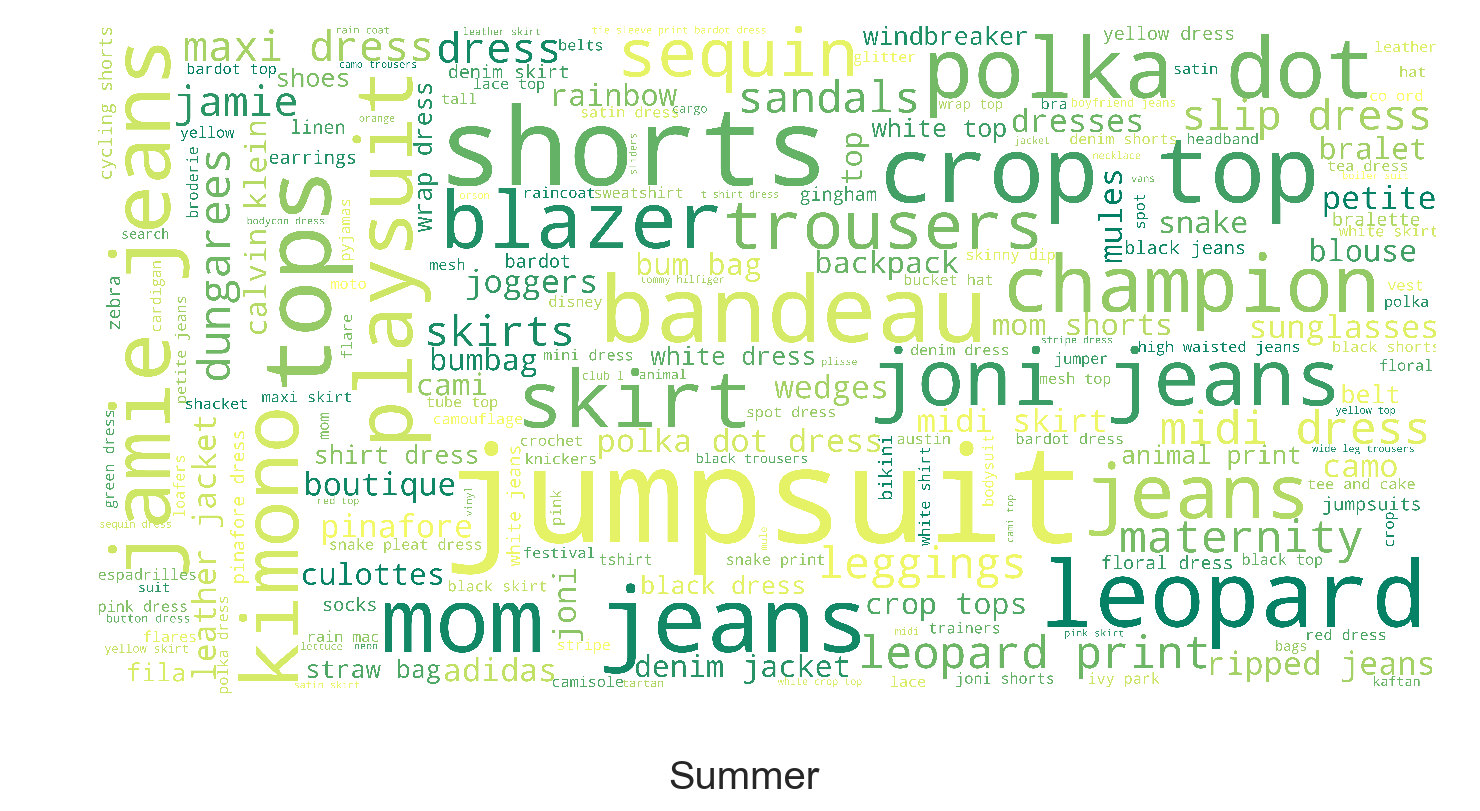

In [45]:
s = df_search_terms.date.apply(lambda x: x.month)
# Filter on May - Aug
m = ((s >= 5) & (s <= 8))
summer_term_counts = df_search_terms[m].groupby('search_term_lower').num_searches.sum()
fig = make_wordcloud(summer_term_counts.to_dict(), 'Summer', colormap='summer')
savefig('onsite_search_tag_cloud_summer')

Top 10 winter searches

In [32]:
winter_term_counts.sort_values(ascending=False).head(25)

search_term_lower
mom jeans         99412
jamie jeans       97699
joni jeans        86969
tops              82012
champion          81664
pinafore          75660
blazer            69316
leggings          65043
jamie             62819
joggers           61264
joni              60716
velvet            60479
sequin            58131
skirt             55667
jumpsuit          54824
crop top          53894
leather jacket    53208
jumper            49824
fur coat          49459
puffer jacket     45089
faux fur          44868
trousers          42721
leopard           42719
borg              42179
satin skirt       40377
Name: num_searches, dtype: int64

Top 10 summer searches

In [33]:
summer_term_counts.sort_values(ascending=False).head(25)

search_term_lower
jumpsuit         126967
shorts            79024
tops              56078
crop top          53339
bandeau           52816
leopard           52644
mom jeans         51496
polka dot         43062
jamie jeans       41013
champion          37993
skirt             37938
kimono            37609
joni jeans        36893
playsuit          36199
blazer            35597
jeans             32137
sequin            31603
trousers          31384
leopard print     31071
midi dress        30986
maternity         30323
leggings          29101
sandals           28821
dungarees         28183
dress             26978
Name: num_searches, dtype: int64

In [34]:
summer_terms = (
    set(summer_term_counts.sort_values(ascending=False).head(25).index)
    - set(winter_term_counts.sort_values(ascending=False).head(25).index)
)
top_summer_terms = summer_term_counts[summer_term_counts.index.isin(list(summer_terms))]
top_summer_terms.sort_values(ascending=False)

search_term_lower
shorts           79024
bandeau          52816
polka dot        43062
kimono           37609
playsuit         36199
jeans            32137
leopard print    31071
midi dress       30986
maternity        30323
sandals          28821
dungarees        28183
dress            26978
Name: num_searches, dtype: int64

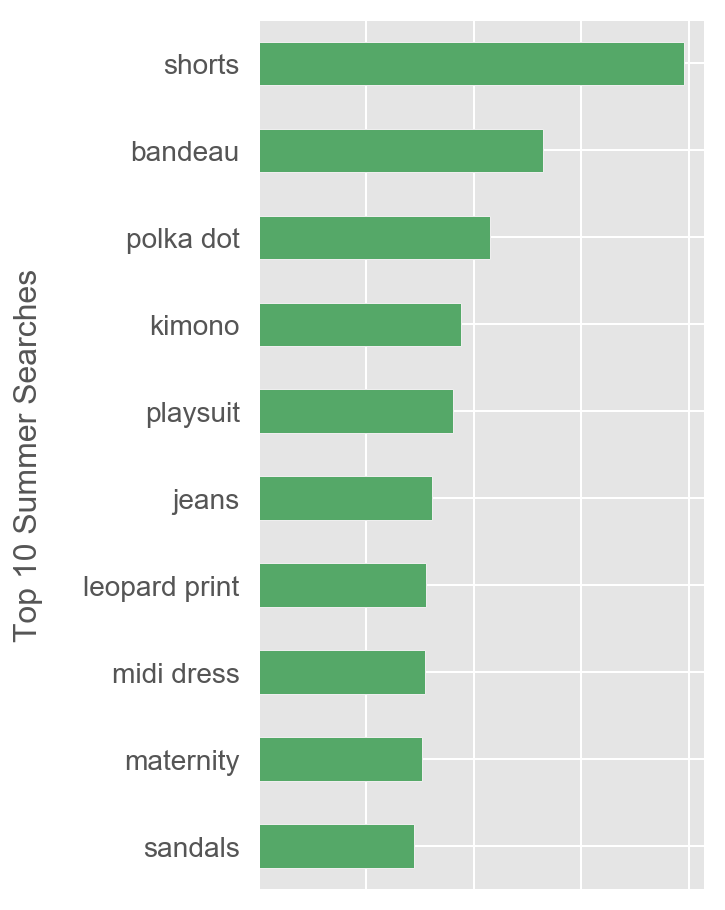

In [39]:
fig = plt.figure(figsize=(4, 8))
top_summer_terms.sort_values(ascending=False).head(10).iloc[::-1].plot.barh(color='g')
plt.ylabel('Top 10 Summer Searches')
ax = plt.gca()
ax.set_xticklabels([])
savefig('onsite_search_top_summer')

In [40]:
winter_terms = (
    set(winter_term_counts.sort_values(ascending=False).head(25).index)
    - set(summer_term_counts.sort_values(ascending=False).head(25).index)
)
top_winter_terms = winter_term_counts[winter_term_counts.index.isin(list(winter_terms))]
top_winter_terms.sort_values(ascending=False)

search_term_lower
pinafore          75660
jamie             62819
joggers           61264
joni              60716
velvet            60479
leather jacket    53208
jumper            49824
fur coat          49459
puffer jacket     45089
faux fur          44868
borg              42179
satin skirt       40377
Name: num_searches, dtype: int64

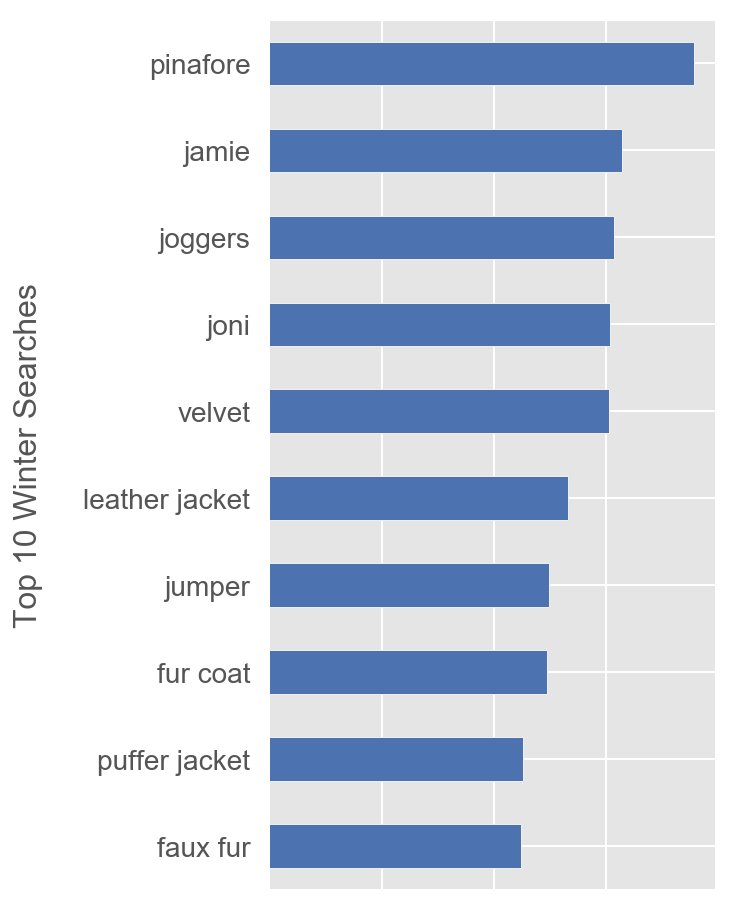

In [41]:
fig = plt.figure(figsize=(4, 8))
top_winter_terms.sort_values(ascending=False).head(10).iloc[::-1].plot.barh(color='b')
plt.ylabel('Top 10 Winter Searches')
ax = plt.gca()
ax.set_xticklabels([])
savefig('onsite_search_top_winter')

### Topic Modeling

In [96]:
import spacy
# Use spaCy instead of NLTK
# To run below, first do: python -m spacy download en

nlp = spacy.load('en')

my_stop_words = ['i', 'a', 'about', 'an', 'are', 'as', 'at', 'be', 'by',
                 'for', 'from', 'how', 'in', 'is', 'it', 'of', 'on', 'or',
                 'that', 'the', 'this', 'to', 'was', 'what', 'when', 'where',
                 'who', 'will', 'with', 'the']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [97]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower  
0                       ,axi dress  
14310             ´boyfriend jeans  
14309  'you me oui' slogan t-shirt  
14308                         ;ace  
14307             ;eather trousers

In [98]:
from tqdm import tqdm

In [99]:
def make_lemmas(text):
    nlp_text = nlp(text)
    lemmas = [w.lemma_ for w in nlp_text
              if not any((w.is_stop, w.is_punct, w.like_num))]
    return lemmas

tqdm.pandas()
search_terms = df_search_terms['search_term_lower'].drop_duplicates()
search_term_lemmas = search_terms.progress_apply(make_lemmas)
search_term_lemmas.name = 'lemmas'
s = pd.concat((search_terms, search_term_lemmas), axis=1).set_index('search_term_lower')['lemmas']

m = pd.Series(True, index=df_search_terms.index)
df_search_terms['lemmas'] = float('nan')
df_search_terms.loc[m, 'lemmas'] \
    = df_search_terms.loc[m, 'search_term_lower'].map(s)

100%|██████████| 2155446/2155446 [4:45:53<00:00, 125.66it/s]  


For a larger dataset, would want to run cell above externally

In [100]:
# Dump terms to file
# f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_lower_terms_dedupe.csv')
# df_search_terms.search_term_lower.drop_duplicates().to_csv(f_path, index=False)

# Run script externally....

# Load results from file

In [103]:
import gensim

In [104]:
m_not_empty = df_search_terms.lemmas.apply(lambda x: len(x) > 0)

# Extract bigrams
tqdm.pandas()
bigram = gensim.models.Phrases(
    df_search_terms.loc[m_not_empty, 'lemmas'].tolist()
)
df_search_terms['bigrams'] = float('nan')
df_search_terms.loc[m_not_empty, 'bigrams'] = (
    df_search_terms.loc[m_not_empty, 'lemmas']
    .progress_apply(lambda x: bigram[x])
)

100%|██████████| 10553370/10553370 [03:25<00:00, 51243.20it/s]


In [105]:
# Create integer corpus for learning algorithms
dictionary = gensim.corpora.Dictionary(df_search_terms.bigrams.dropna().tolist())
df_search_terms['corpus'] = float('nan')
df_search_terms.loc[m_not_empty, 'corpus'] = (
    df_search_terms.loc[m_not_empty, 'bigrams']
    .progress_apply(lambda x: dictionary.doc2bow(x))
)

100%|██████████| 10553370/10553370 [01:17<00:00, 136811.50it/s]


In [106]:
# Dump results of long computation

import pickle

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_nlp_gensim_dictionary.pkl')
# if os.path.isfile(f_path):
#     raise Exception(
#         'File exists! ({}) Run line below in separate cell to overwrite it. '
#         'Otherwise just run cell below to load file.'.format(f_path))

with open(f_path, 'wb') as f:
    pickle.dump(dictionary, f)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_nlp')
# if os.path.isfile('{}.csv'.format(f_path)):
#     raise Exception(
#         'File exists! ({}) Run line below in separate cell to overwrite it. '
#         'Otherwise just run cell below to load file.'.format(f_path))
    
df_search_terms.to_csv('{}.csv'.format(f_path), index=False)
df_search_terms.to_pickle('{}.pkl'.format(f_path))

#### Data-load checkpoint

In [106]:
# Load data
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_nlp_gensim_dictionary.pkl')
import pickle
with open(f_path, 'rb') as f:
    dictionary = pickle.load(f)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_terms_2017_2019_nlp.pkl')
df_search_terms = pd.read_pickle(f_path)

In [3]:
dictionary

In [4]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower                   lemmas  \
0                       ,axi dress             [axi, dress]   
14310             ´boyfriend jeans     [´, boyfriend, jean]   
14309  'you me oui' slogan t-shirt  [oui, slogan, t, shirt]   
14308                         ;ace                    [ace]   
14307             ;eather trousers        [eather, trouser]   

                       bigrams                            corpus  
0                 [axi, dress]                  [(0, 1), (1, 1)]  
14310     [´, boyfriend, jean]          [(2, 1), (3, 1), (4, 1)]  
14309  [oui, slogan, t, shirt]  [(5, 1), (6, 1), (7, 1), (8, 1)]  
14308                    [ace]                          [(9, 1)]  
14307        [eather, trouser]                [(10, 1), (11, 1)]

Note: default behaviour for Gensim e.g.
> 2019-06-05 15:31:34,007 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 8585316 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000

In [8]:
# Log to file (you'll probably want to delete this after)

import logging
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'onsite_search_gensim.log')
logging.basicConfig(filename=f_path, format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Running a test first...

In [9]:
# Latent Dirichlet Allocation (LDA) model

from gensim.models import LdaModel
ldamodel = LdaModel(
    corpus=df_search_terms.corpus.dropna().tolist()[:10],
    num_topics=5,
    id2word=dictionary,
)

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [10]:
f_path

'/Volumes/GoogleDrive/My Drive/ga-data-mining/data/interim/onsite_search_gensim.log'

In [11]:
cat '/Volumes/GoogleDrive/My Drive/ga-data-mining/data/interim/onsite_search_gensim.log'

2019-06-05 16:10:48,353 : INFO : using symmetric alpha at 0.2
2019-06-05 16:10:48,358 : INFO : using symmetric eta at 0.2
2019-06-05 16:10:48,425 : INFO : using serial LDA version on this node
2019-06-05 16:10:48,641 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 10 documents, updating model once every 10 documents, evaluating perplexity every 10 documents, iterating 50x with a convergence threshold of 0.001000
2019-06-05 16:10:48,642 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-06-05 16:10:48,823 : INFO : -60130.732 per-word bound, inf perplexity estimate based on a held-out corpus of 10 documents with 24 words
2019-06-05 16:10:48,823 : INFO : PROGRESS: pass 0, at document #10/10
2019-06-05 16:10:49,221 : INFO : topic #0 (0.200): 0.000*"k" + 0.000*"necjlace" + 0.000*"05a43mwht" + 0.000*"c'_moi" + 0.000*"shirt" + 0.000*"ace" + 0.000*"t" + 0.00

Training on the full dataset (running externally `onsite_search_gensim_lda.py`)

In [ ]:
# Latent Dirichlet Allocation (LDA) model

# from gensim.models import LdaModel
# ldamodel = LdaModel(
#     corpus=df_search_terms.corpus.dropna().tolist(),
#     num_topics=20,
#     id2word=dictionary,
# )

In [20]:
# Save the model

# f_path = '../../models/onsite_search_terms_lda_2017_2019_20_topic.model'
# if os.path.isfile(f_path):
#     raise Exception(
#         'File exists! ({}) Run line below in separate cell to overwrite it. '
#         'Otherwise just run cell below to load file.'.format(f_path))

# ldamodel.save(f_path)

#### Data-load checkpoint

In [107]:
# Load the model

import gensim
f_path = '../../models/onsite_search_terms_lda_2017_2019_20_topic.model'
ldamodel = gensim.models.LdaModel.load(f_path)

INFO:gensim.utils:loading LdaModel object from ../../models/onsite_search_terms_lda_2017_2019_20_topic.model
INFO:gensim.utils:loading expElogbeta from ../../models/onsite_search_terms_lda_2017_2019_20_topic.model.expElogbeta.npy with mmap=None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:setting ignored attribute id2word to None
INFO:gensim.utils:setting ignored attribute state to None
INFO:gensim.utils:loaded ../../models/onsite_search_terms_lda_2017_2019_20_topic.model
INFO:gensim.utils:loading LdaState object from ../../models/onsite_search_terms_lda_2017_2019_20_topic.model.state
INFO:gensim.utils:loaded ../../models/onsite_search_terms_lda_2017_2019_20_topic.model.state


In [108]:
# Model visualization

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(
    ldamodel,
    df_search_terms.corpus.dropna().tolist(),
    dictionary
)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.134726  0.161007       1        1  6.888501
12     0.126918  0.154111       2        1  6.777255
7      0.297280 -0.301254       3        1  6.361829
18     0.093757  0.125274       4        1  5.919718
14     0.082408  0.115585       5        1  5.806785
4      0.265270 -0.307055       6        1  5.490545
11     0.065058  0.100985       7        1  5.384727
6      0.039523  0.079939       8        1  5.284969
5      0.000173  0.048602       9        1  5.129102
0     -0.077429 -0.008883      10        1  5.028252
13     0.036819  0.077754      11        1  4.967427
19     0.009328  0.055773      12        1  4.803558
10     0.000077  0.048540      13        1  4.748663
1     -0.040059  0.018050      14        1  4.625901
8     -0.074427 -0.006774      15        1  4.551650
17    -0.013134  0.038334      16        1  4.508730
9     -0.204914 -0.087800      17        1  3.670846
3     -0.223413 -0.096843      18        1  3.457620
16    -0.258981 -0.107672      19        1  3.296962
2     -0.258981 -0.107672      20        1  3.296962, topic_info=       Category          Freq                    Term         Total  loglift  \
term                                                                           
1       Default  1.200326e+06                   dress  1.200326e+06  30.0000   
3       Default  1.438875e+06                    jean  1.438875e+06  29.0000   
1476    Default  1.071950e+06                   black  1.071950e+06  28.0000   
11      Default  8.807950e+05                 trouser  8.807950e+05  27.0000   
42      Default  7.619390e+05                    crop  7.619390e+05  26.0000   
1663    Default  7.167150e+05                     bag  7.167150e+05  25.0000   
1482    Default  6.999370e+05                   skirt  6.999370e+05  24.0000   
1546    Default  6.714220e+05                  jacket  6.714220e+05  23.0000   
6       Default  6.050730e+05                   shirt  6.050730e+05  22.0000   
25      Default  5.067410e+05                  stripe  5.067410e+05  21.0000   
66      Default  4.899170e+05                  petite  4.899170e+05  20.0000   
1774    Default  4.588780e+05                     rip  4.588780e+05  19.0000   
1904    Default  4.018710e+05                    ring  4.018710e+05  18.0000   
1840    Default  4.483220e+05                    blue  4.483220e+05  17.0000   
15      Default  4.213780e+05                   print  4.213780e+05  16.0000   
65      Default  3.480130e+05                 topshop  3.480130e+05  15.0000   
1700    Default  3.889060e+05                   jamie  3.889060e+05  14.0000   
74      Default  3.756050e+05                    coat  3.756050e+05  13.0000   
1495    Default  3.224550e+05                    boot  3.224550e+05  12.0000   
1203    Default  3.154640e+05                    heel  3.154640e+05  11.0000   
8       Default  3.255530e+05                       t  3.255530e+05  10.0000   
50      Default  2.788200e+05                  blouse  2.788200e+05   9.0000   
1841    Default  2.874480e+05                     mom  2.874480e+05   8.0000   
1792    Default  2.746480e+05                    high  2.746480e+05   7.0000   
55      Default  2.355880e+05                     tie  2.355880e+05   6.0000   
45      Default  2.505100e+05                  bikini  2.505100e+05   5.0000   
1591    Default  2.301170e+05                 leather  2.301170e+05   4.0000   
1652    Default  2.317070e+05                     rib  2.317070e+05   3.0000   
1632    Default  1.913940e+05                    maxi  1.913940e+05   2.0000   
1617    Default  1.793350e+05                  buckle  1.793350e+05   1.0000   
...         ...           ...                     ...           ...      ...   
158163  Topic20  1.543007e+00               fjallanka  6.502916e+00   1.9737   
158024  Topic20  1.543007e+00  504544157501909a30ncrm  6.502916e+00   1

In [13]:
# Export as web app

pyLDAvis.disable_notebook()
p = pyLDAvis.gensim.prepare(
    ldamodel,
    df_search_terms.corpus.dropna().tolist(),
    dictionary
)
pyLDAvis.save_html(p, '../../results/reports/onsite_search_terms_lda_2017_2019_20_topic.html')

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


The size of the bubble measures the importance of the topics, relative to the data.

The terms are ordered by saliency (how much the term tells you about the topic).

The relevance slider can be used to adjust saliency scores.

In [95]:
num_topics = 20

In [104]:
censored = [9]
[x for x in ldamodel.show_topics(num_topics=num_topics) if x[0] not in censored]

[(0,
  '0.454*"stripe" + 0.337*"coat" + 0.050*"slogan" + 0.027*"slouch" + 0.013*"texture" + 0.001*"romance" + 0.000*"white" + 0.000*"trench" + 0.000*"short" + 0.000*"woman"'),
 (1,
  '0.858*"trouser" + 0.024*"s" + 0.022*"£" + 0.002*"oh_love" + 0.001*"romantic" + 0.000*"suit" + 0.000*"woman" + 0.000*"cargo" + 0.000*"utility" + 0.000*"white"'),
 (2,
  '0.000*"☝_o10.43⑦3.l91ㅇ" + 0.000*"☝_남궁실장ღ" + 0.000*"bmt안마이벤트" + 0.000*"bmt안마주소" + 0.000*"↕" + 0.000*"⊙" + 0.000*"bmt안마아이패드초이스" + 0.000*"bmt안마위치" + 0.000*"bmt안마가격" + 0.000*"bmt안마방"'),
 (3,
  '0.524*"ring" + 0.110*"backpack" + 0.002*"detailed" + 0.002*"bailey" + 0.000*"horn" + 0.000*"shirred" + 0.000*"cami" + 0.000*"gold" + 0.000*"mini" + 0.000*"ear"'),
 (4,
  '0.319*"jamie" + 0.289*"jean" + 0.102*"straight" + 0.083*"leg" + 0.068*"hem" + 0.043*"v" + 0.041*"raw_hem" + 0.007*"let" + 0.003*"ballerina" + 0.000*"moto"'),
 (5,
  '0.630*"bag" + 0.126*"zip" + 0.081*"fur" + 0.071*"faux" + 0.009*"bucket" + 0.009*"handle" + 0.002*"oui" + 0.001*"ashton" 

### Tracking trends over time

Given a gensim model, label a corpus by topic and plot them over time. How do they change relative to one another?

Top topics may follow similar trends to global search patterns. Instead, look at "% of searches that are topic".

First, we need to label the training data

In [6]:
from tqdm import tqdm

In [7]:
tqdm.pandas()

m = ~(df_search_terms.corpus.isnull())
df_search_terms['lda_20_topic_scores'] = float('nan')
df_search_terms.loc[m, 'lda_20_topic_scores'] = (
    df_search_terms.loc[m, 'corpus']
    .progress_apply(lambda x: ldamodel[x])
)

100%|██████████| 10553370/10553370 [5:23:48<00:00, 543.19it/s]    


In [8]:
df_search_terms.head()

date                  search_term  num_searches  \
0     2017-10-01                   ,axi dress             1   
14310 2017-10-01             ´boyfriend jeans             1   
14309 2017-10-01  'you me oui' slogan t-shirt             1   
14308 2017-10-01                         ;ace             1   
14307 2017-10-01             ;eather trousers             1   

                 search_term_lower                   lemmas  \
0                       ,axi dress             [axi, dress]   
14310             ´boyfriend jeans     [´, boyfriend, jean]   
14309  'you me oui' slogan t-shirt  [oui, slogan, t, shirt]   
14308                         ;ace                    [ace]   
14307             ;eather trousers        [eather, trouser]   

                       bigrams                            corpus  \
0                 [axi, dress]                  [(0, 1), (1, 1)]   
14310     [´, boyfriend, jean]          [(2, 1), (3, 1), (4, 1)]   
14309  [oui, slogan, t, shirt]  [(5, 1), (6, 1), (7, 1), (8, 1)]   
14308                    [ace]                          [(9, 1)]   
14307        [eather, trouser]                [(10, 1), (11, 1)]   

                                     lda_20_topic_scores  
0      [(0, 0.025000004), (1, 0.025000004), (2, 0.025...  
14310  [(0, 0.025000004), (1, 0.025000004), (2, 0.025...  
14309  [(0, 0.21001838), (1, 0.010001043), (2, 0.0100...  
14308  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (...  
14307  [(0, 0.025000004), (1, 0.5249999), (2, 0.02500...

In [9]:
m = ~(df_search_terms['lda_20_topic_scores'].isnull())

df_search_terms['lda_20_topic'] = float('nan')
df_search_terms.loc[m, 'lda_20_topic'] = (
    df_search_terms.loc[m, 'lda_20_topic_scores']
    .progress_apply(lambda x: sorted(x, key=lambda x: x[1], reverse=True)[0][0])
)

df_search_terms['lda_20_topic_score'] = float('nan')
df_search_terms.loc[m, 'lda_20_topic_score'] = (
    df_search_terms.loc[m, 'lda_20_topic_scores']
    .progress_apply(lambda x: sorted(x, key=lambda x: x[1], reverse=True)[0][1])
)

100%|██████████| 10553370/10553370 [03:08<00:00, 56133.27it/s]


In [10]:
pd.options.display.max_colwidth = 100

In [11]:
df_search_terms.sample(10)

date          search_term  num_searches    search_term_lower  \
5217186 2018-10-05  petite skinny jeans             1  petite skinny jeans   
7036759 2019-01-05   black borg jackets             2   black borg jackets   
3099553 2018-04-15      tankini bottoms             1      tankini bottoms   
573364  2017-11-08            23r04moat             2            23r04moat   
9001248 2019-04-11            size quiz             1            size quiz   
8991789 2019-04-10        canaval shoes             1        canaval shoes   
529812  2017-11-05      green new coats             1      green new coats   
285453  2017-10-19           skirt pink             1           skirt pink   
6699458 2018-12-24          bootß socks             1          bootß socks   
5181207 2018-10-02            celestial             1            celestial   

                         lemmas                 bigrams  \
5217186  [petite, skinny, jean]  [petite, skinny, jean]   
7036759   [black, borg, jacket]   [black, borg, jacket]   
3099553       [tankini, bottom]       [tankini, bottom]   
573364              [23r04moat]             [23r04moat]   
9001248            [size, quiz]            [size, quiz]   
8991789         [canaval, shoe]         [canaval, shoe]   
529812       [green, new, coat]      [green, new, coat]   
285453            [skirt, pink]           [skirt, pink]   
6699458           [bootß, sock]           [bootß, sock]   
5181207             [celestial]             [celestial]   

                                    corpus  \
5217186       [(3, 1), (66, 1), (1643, 1)]   
7036759  [(1476, 1), (1546, 1), (2197, 1)]   
3099553             [(1535, 1), (7586, 1)]   
573364                          [(980, 1)]   
9001248            [(2210, 1), (22145, 1)]   
8991789           [(1549, 1), (453055, 1)]   
529812     [(74, 1), (1773, 1), (5926, 1)]   
285453              [(1482, 1), (1874, 1)]   
6699458           [(1496, 1), (383077, 1)]   
5181207                       [(20961, 1)]   

                                                                                         lda_20_topic_scores  \
5217186  [(0, 0.012500016), (1, 0.012500016), (2, 0.012500016), (3, 0.012500016), (4, 0.012500016), (5, 0...   
7036759  [(0, 0.016666675), (1, 0.016666675), (2, 0.016666675), (3, 0.016666675), (4, 0.016666675), (5, 0...   
3099553  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   
573364   [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   
9001248  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   
8991789  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   
529812   [(0, 0.5249998), (1, 0.025000012), (2, 0.025000012), (3, 0.025000012), (4, 0.025000012), (5, 0.0...   
285453   [(0, 0.025000006), (1, 0.025000006), (2, 0.025000006), (3, 0.025000006), (4, 0.025000006), (5, 0...   
6699458  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   
5181207  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   

         lda_20_topic  lda_20_topic_score  
5217186           7.0              0.5125  
7036759          14.0              0.3500  
3099553           0.0              0.0500  
573364            0.0              0.0500  
9001248           0.0              0.0500  
8991789           0.0              0.0500  
529812            0.0              0.5250  
285453           18.0              0.5250  
6699458           0.0              0.0500  
5181207           0.0              0.0500

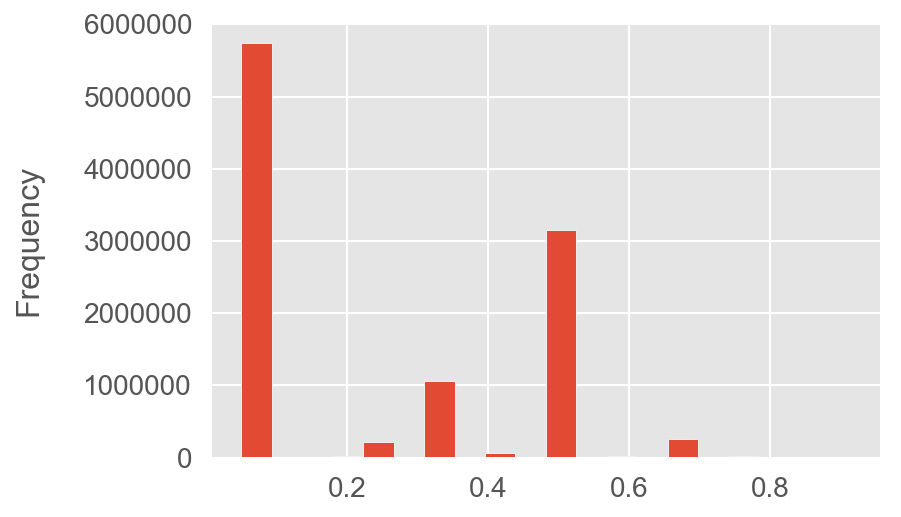

In [12]:
df_search_terms.lda_20_topic_score.plot.hist(bins=20)

Let's throw out anything less than 0.5

In [13]:
m = df_search_terms['lda_20_topic_score'].fillna(0) >= 0.5

df_search_terms['topic'] = float('nan')
df_search_terms.loc[m, 'topic'] = df_search_terms.loc[m, 'lda_20_topic']

In [ ]:
# Dump results of long computation

def dump_df(df, name, csv=True, pkl=True):
    if not any((csv, pkl)):
        print('Not saving to file')
    
    f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', name)
    if os.path.isfile('{}.csv'.format(f_path)):
        raise Exception(
            'File exists! ({}) Run line below in separate cell to overwrite it. '
            'Otherwise just run cell below to load file.'.format(f_path))

    if csv:
        file = '{}.csv'.format(f_path)
        print('Writing to {}'.format(file))
        df_search_terms.to_csv(file, index=False)
        
    if pkl:
        file = '{}.pkl'.format(f_path)
        print('Writing to {}'.format(file))
        df_search_terms.to_pickle(file)
    
    
name = 'onsite_search_terms_2017_2019_nlp_topic_labels_'
dump_df(df_search_terms, name, csv=False)

#### Data-load checkpoint

In [109]:
# Load data
name = 'onsite_search_terms_2017_2019_nlp_topic_labels'
f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', '{}.csv'.format(name))
df_search_terms = pd.read_csv(f_path)

df_search_terms['date'] = pd.to_datetime(
    df_search_terms['date']
)

In [16]:
df_search_terms.sample(5)

date        search_term  num_searches  search_term_lower  \
1950979 2018-01-27        ts61h15mred             1        ts61h15mred   
3844608 2018-05-15    highwastes jens             1    highwastes jens   
8489975 2019-03-17  leather tie pants             1  leather tie pants   
5002908 2018-09-20          09a22psal             1          09a22psal   
6879896 2018-12-30  buy now pay later             1  buy now pay later   

                       lemmas               bigrams  \
1950979          [ts61h15mre]          [ts61h15mre]   
3844608      [highwaste, jen]      [highwaste, jen]   
8489975  [leather, tie, pant]  [leather, tie, pant]   
5002908           [09a22psal]           [09a22psal]   
6879896     [buy, pay, later]      [buy_pay, later]   

                                  corpus  \
1950979                    [(157064, 1)]   
3844608           [(2028, 1), (4526, 1)]   
8489975  [(55, 1), (1199, 1), (1591, 1)]   
5002908                    [(292128, 1)]   
6879896           [(2741, 1), (2742, 1)]   

                                                                                         lda_20_topic_scores  \
1950979  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   
3844608  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   
8489975  [(0, 0.016666692), (1, 0.016666692), (2, 0.016666692), (3, 0.016666692), (4, 0.016666692), (5, 0...   
5002908  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   
6879896  [(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.0...   

         lda_20_topic  lda_20_topic_score  topic  
1950979           0.0                0.05    NaN  
3844608           0.0                0.05    NaN  
8489975          17.0                0.35    NaN  
5002908           0.0                0.05    NaN  
6879896           0.0                0.05    NaN

We have labels (given our confidence cutoff of 0.5) for about half of the rows

In [5]:
df_search_terms.topic.isnull().sum() / df_search_terms.shape[0]

0.6774638367865058

Now we have topic labels, let's generate the charts.

In [21]:
topics = df_search_terms.topic.value_counts().index.sort_values().tolist()
topics

[0.0,
 1.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 17.0,
 18.0,
 19.0]

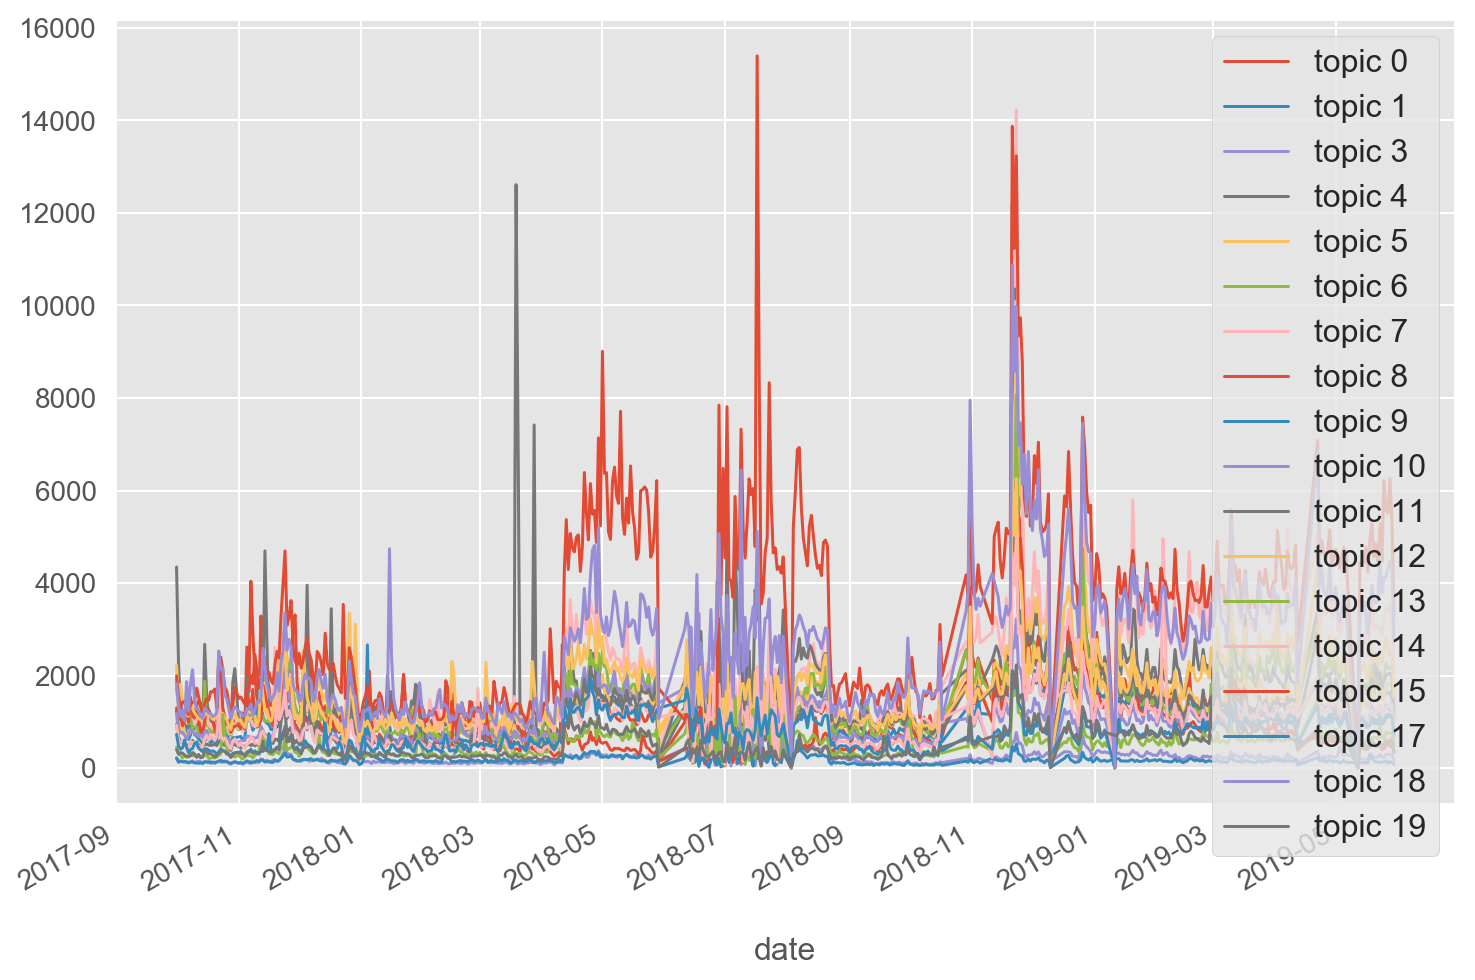

In [57]:
fig, ax = plt.subplots()
for topic in topics:
    m = df_search_terms.topic == topic
    df_search_terms[m].groupby('date').num_searches.sum().plot(ax=ax, label='topic {:.0f}'.format(topic))
    plt.legend()

Plot by week

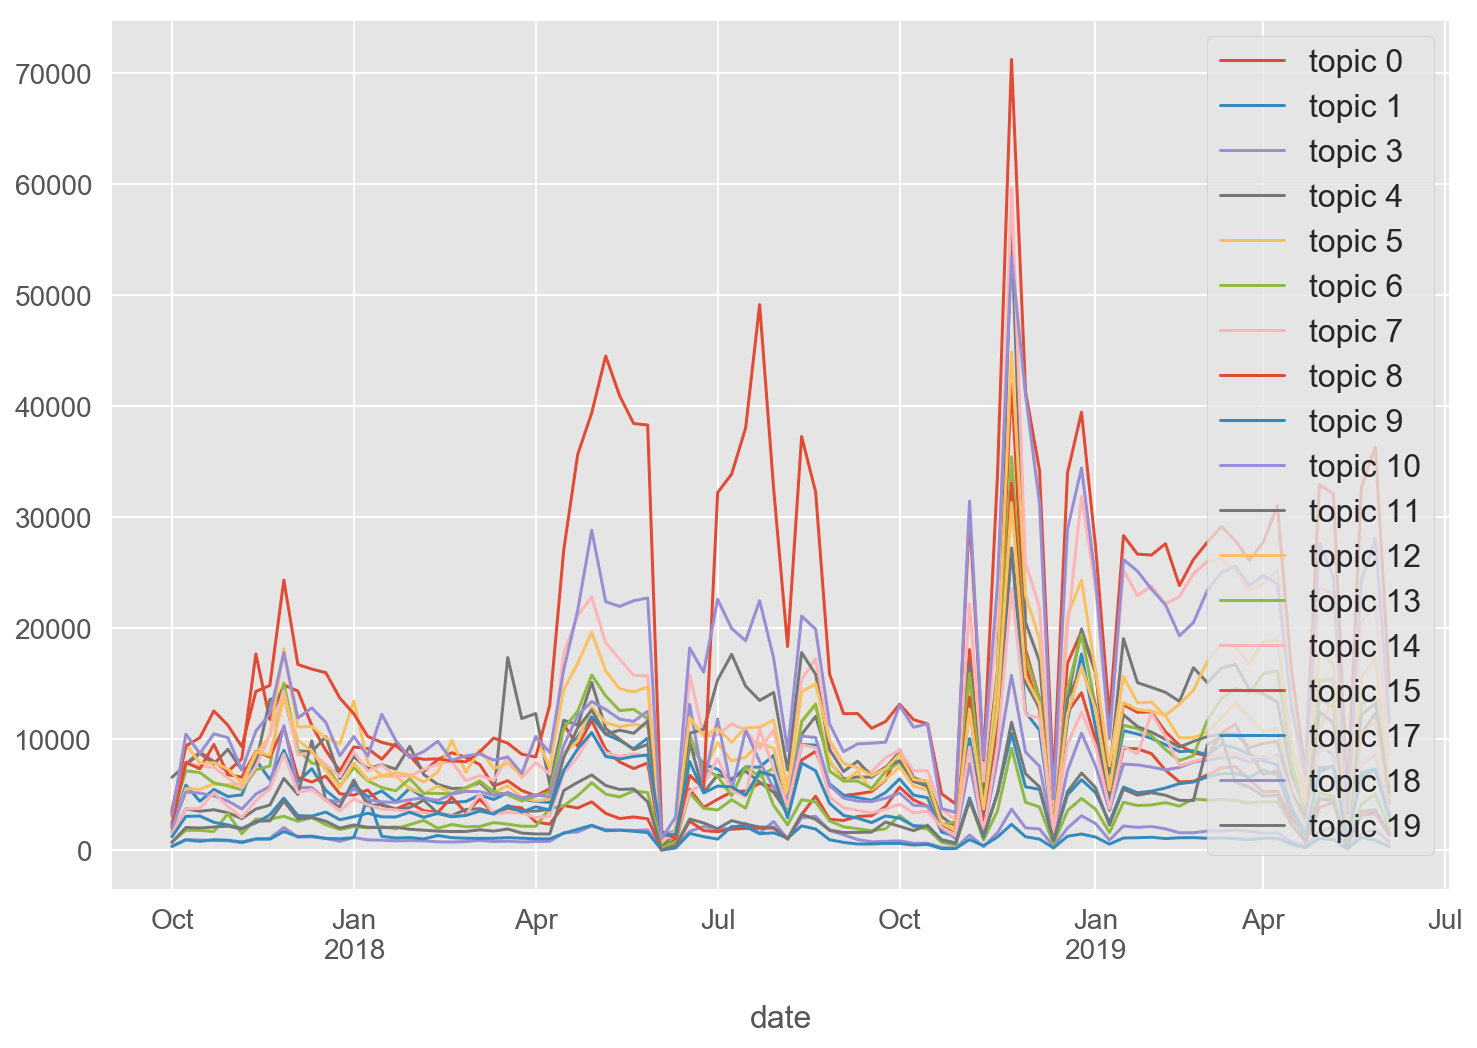

In [58]:
fig, ax = plt.subplots()
for topic in topics:
    m = df_search_terms.topic == topic
    s = df_search_terms[m].groupby(pd.Grouper(key='date', freq='W-MON')).num_searches.sum().dropna()
    s.plot(ax=ax, label='topic {:.0f}'.format(topic))
    plt.legend()

Now look at the ratios...

Being careful to handle the cases where there might not be a search in a given week, we use `pd.date_range` to generate a canvas and post the data onto it.

In [61]:
def plot_trends(
    df,
    output_name='onsite_search_topic_relative_trends',
    groupby='week',
):
    if groupby == 'week':
        freq = '7D'
        grouper_freq = 'W-MON'
    elif groupby == 'month':
        freq = 'M'
        grouper_freq = 'M'
    else:
        raise ValueError('Invalid option for groupby ({})'.format(groupby))

    s = df.groupby(pd.Grouper(key='date', freq=grouper_freq)).size().index.sort_values()
    min_day = s.min()
    max_day = s.max()
    s_dates = pd.date_range(
        start=min_day,
        end=max_day,
        freq=freq,
    )
    canvas_post = lambda x: pd.DataFrame(s_dates, columns=['date']).set_index('date').join(x, how='outer')['num_searches']
    s_total = df.groupby(pd.Grouper(key='date', freq=grouper_freq)).num_searches.sum()
    s_total = canvas_post(s_total)

    fig, ax = plt.subplots()
    for topic in topics:
        m = df.topic == topic
        s = df[m].groupby(pd.Grouper(key='date', freq=grouper_freq)).num_searches.sum()
        # Post the data to the canvas
        s = (canvas_post(s) / s_total)
        s.dropna().plot(ax=ax, label='topic {:.0f}'.format(topic), lw=2)
        plt.legend()

    plt.xlabel('Date')
    plt.ylabel('Onsite Search Topic Frequency')
    savefig(output_name)

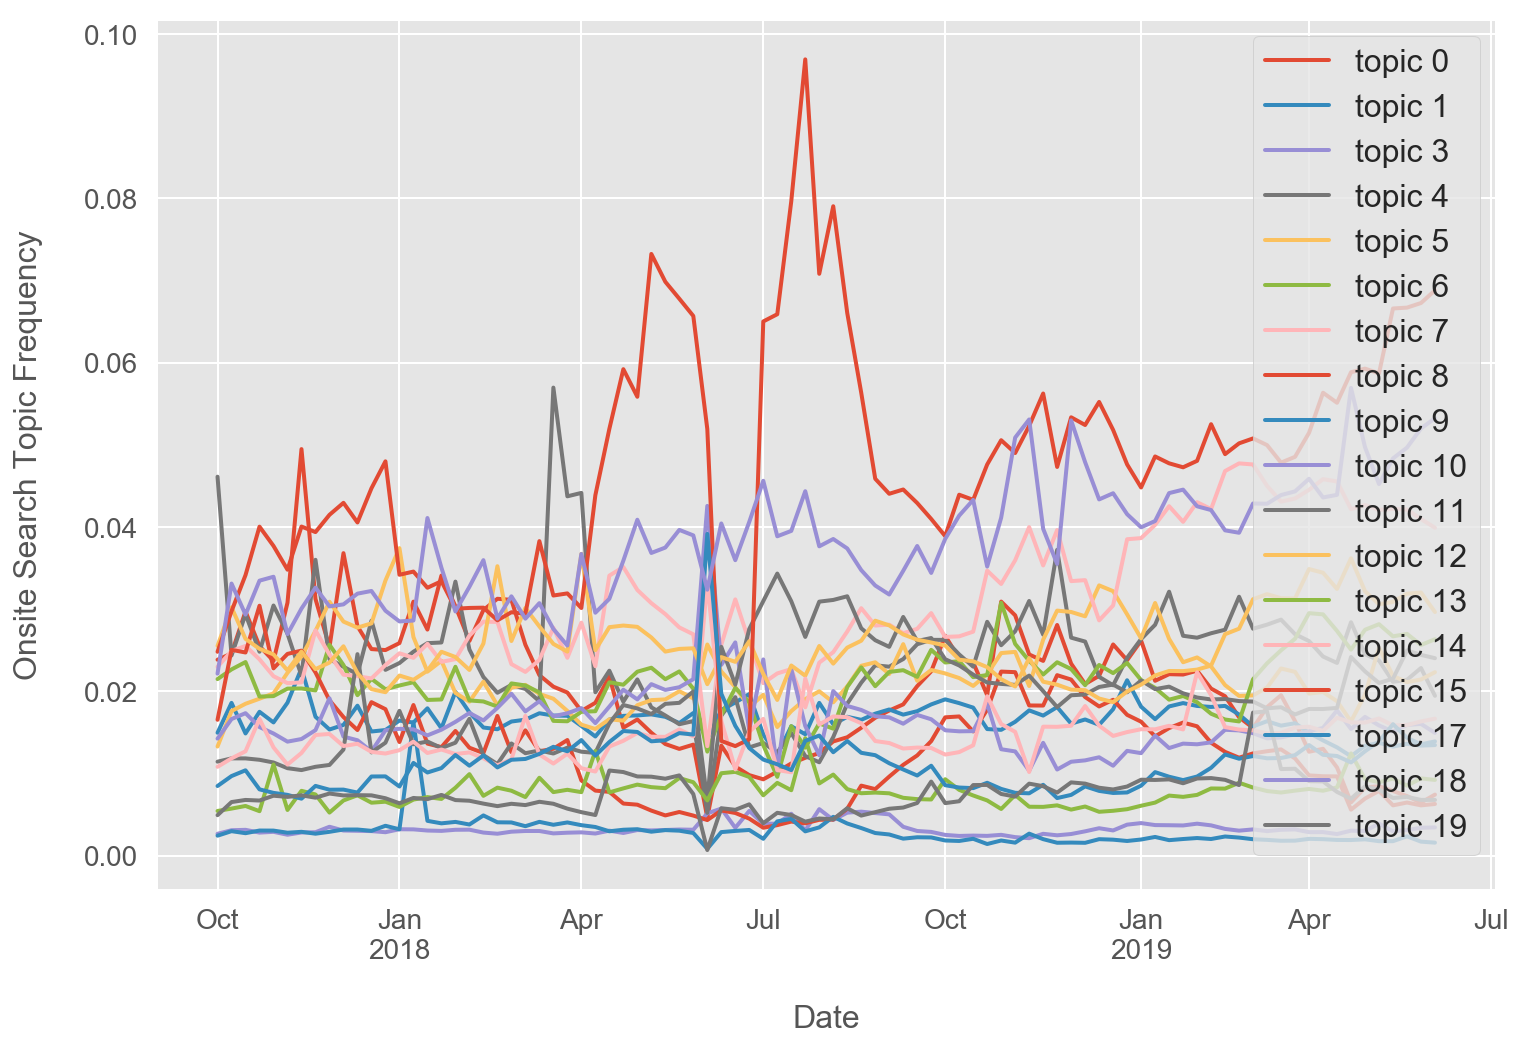

In [60]:
# m = (df_search_terms.date < '2018-05-01') | (df_search_terms.date > '2018-08-01')
plot_trends(df_search_terms)

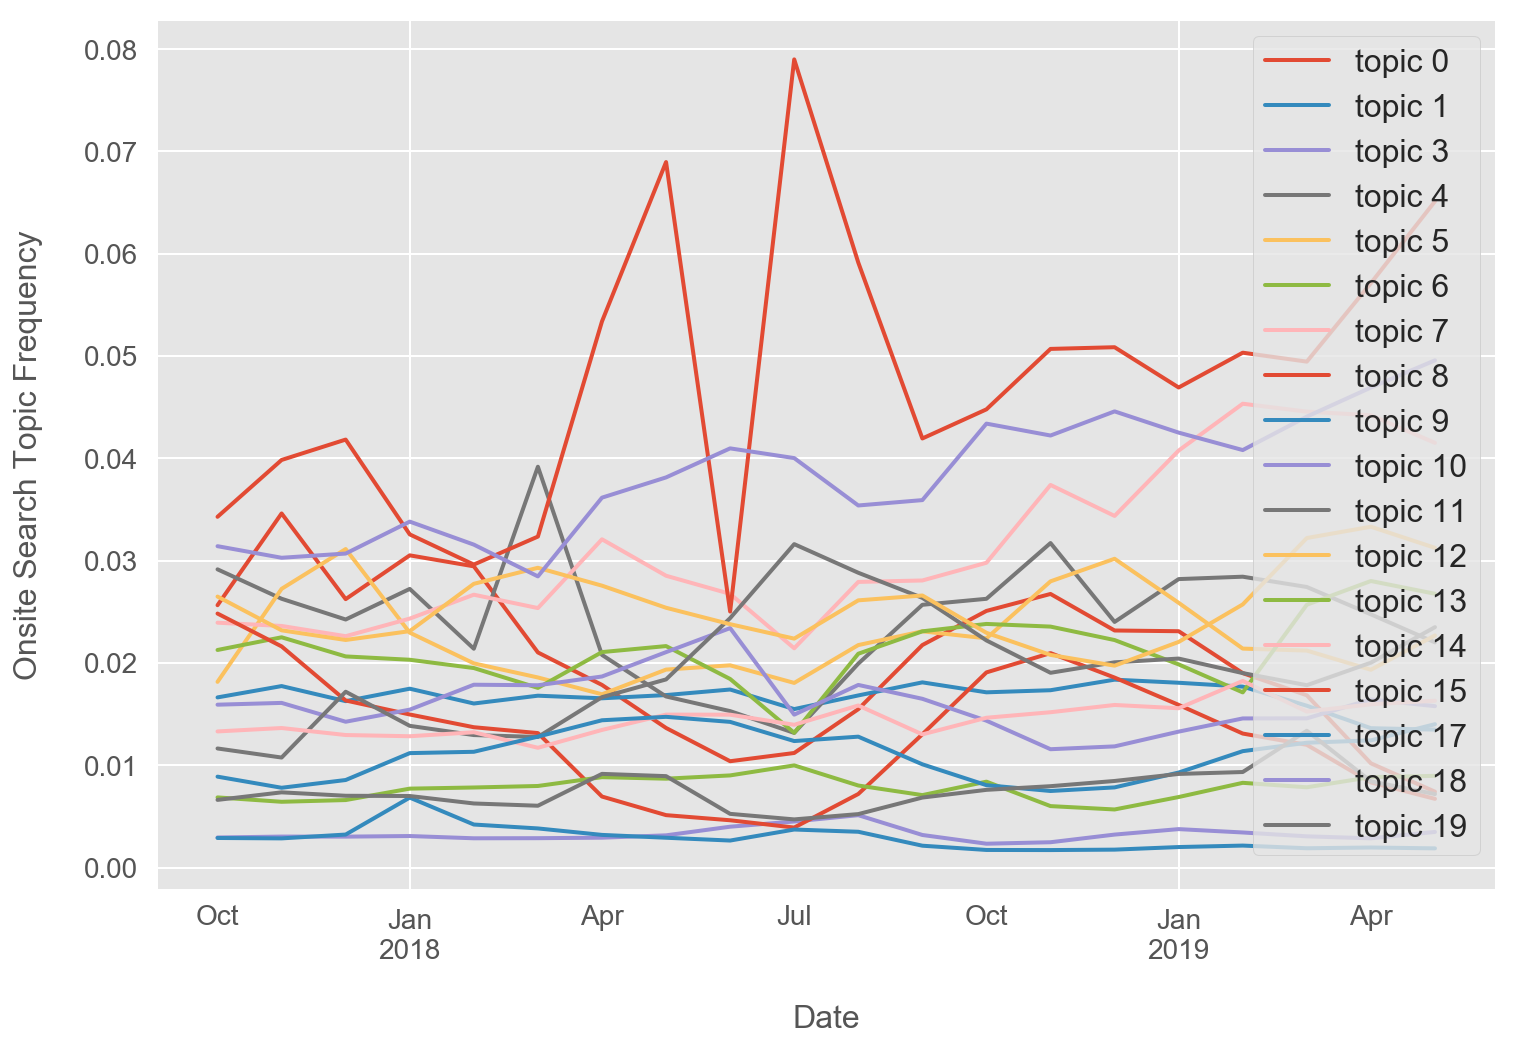

In [62]:
plot_trends(df_search_terms, groupby='month')

In [78]:
s = df_search_terms.groupby(pd.Grouper(key='date', freq='W-MON')).size()
s.sort_index()

Looking at the counts above, we see that we're missing data for 2018-06 :(

```
2018-05-21    168697
2018-05-28    169620
2018-06-04     10400
2018-06-11     23104
2018-06-18    153420
2018-06-25    126540
```

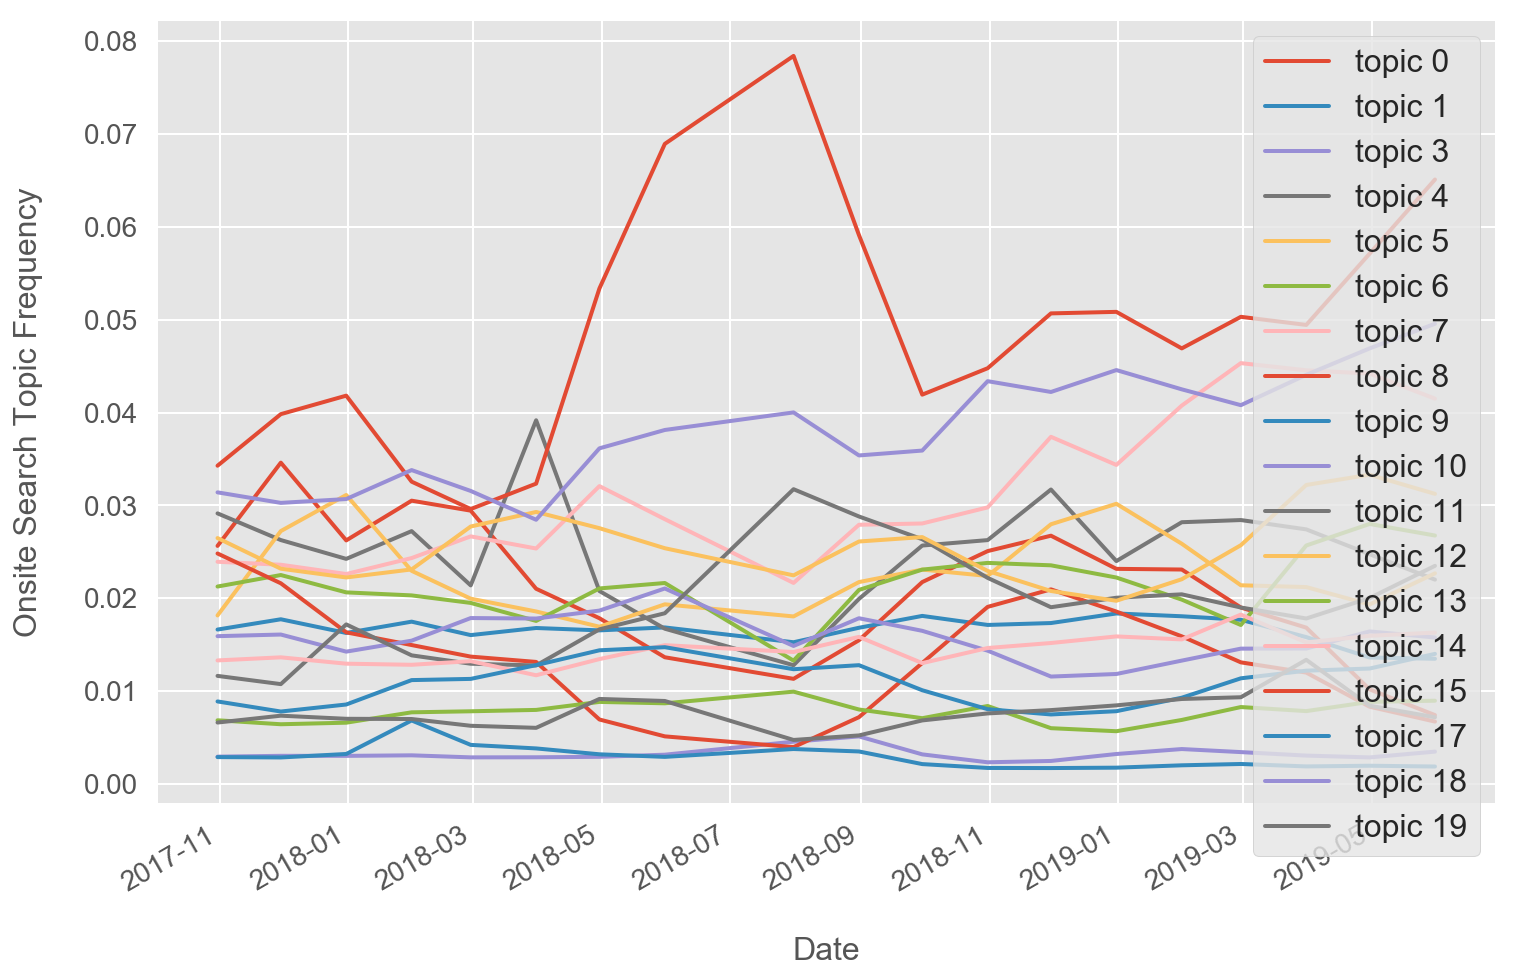

In [77]:
m = (df_search_terms.date < '2018-06-01') | (df_search_terms.date > '2018-07-01')
plot_trends(df_search_terms[m], groupby='month')

This is very close to the final result I'm looking for.

Now I need to add manual labels where it makes sense and look for trends.

In [102]:
ldamodel_topic_words = {i: list(re.findall(r'\*"([^"]+)"', v)) for i, v in ldamodel.show_topics(num_topics=20)}
censored = [9]
{k: v for k, v in ldamodel_topic_words.items() if k not in censored}

{0: ['stripe',
  'coat',
  'slogan',
  'slouch',
  'texture',
  'romance',
  'white',
  'trench',
  'short',
  'woman'],
 1: ['trouser',
  's',
  '£',
  'oh_love',
  'romantic',
  'suit',
  'woman',
  'cargo',
  'utility',
  'white'],
 2: ['☝_o10.43⑦3.l91ㅇ',
  '☝_남궁실장ღ',
  'bmt안마이벤트',
  'bmt안마주소',
  '↕',
  '⊙',
  'bmt안마아이패드초이스',
  'bmt안마위치',
  'bmt안마가격',
  'bmt안마방'],
 3: ['ring',
  'backpack',
  'detailed',
  'bailey',
  'horn',
  'shirred',
  'cami',
  'gold',
  'mini',
  'ear'],
 4: ['jamie',
  'jean',
  'straight',
  'leg',
  'hem',
  'v',
  'raw_hem',
  'let',
  'ballerina',
  'moto'],
 5: ['bag',
  'zip',
  'fur',
  'faux',
  'bucket',
  'handle',
  'oui',
  'ashton',
  'shoulder',
  'paper'],
 6: ['jacket',
  'waist',
  'wide_leg',
  'ruche',
  'wedge',
  'indigo',
  'look',
  'detail',
  'rain_mac',
  'denim'],
 7: ['jean',
  'skinny',
  'slip',
  'leigh',
  'asymmetric',
  'joni',
  'white',
  'waiste',
  'woman',
  'moto'],
 8: ['boot',
  'buckle',
  'knit',
  'split',
  'ankl

In [128]:
manual_topic_map = {
    4: "Jeans",
    5: "Handbags",
    7: "Jeans",
    10: "Short Sleeve Tops",
    11: "Exotic Styles",
    12: "Long Sleeve Tops",
    15: "Dresses",
}

In [137]:
df_search_terms['topic_name'] = float('nan')
m = ~(df_search_terms.topic.isnull())
df_search_terms.loc[m, 'topic_name'] = df_search_terms.loc[m, 'topic'].map(manual_topic_map)

In [138]:
topic_names = df_search_terms.topic_name.value_counts().index.sort_values().tolist()
topic_names

['Dresses',
 'Exotic Styles',
 'Handbags',
 'Jeans',
 'Long Sleeve Tops',
 'Short Sleeve Tops']

In [190]:
def plot_trends(
    df,
    topic_names,
    output_name='onsite_search_topic_relative_trends',
    groupby='week',
    filter_on_topics=[],
):
    if groupby not in (('day', 'week', 'month')):
        raise ValueError('Invalid option for groupby ({})'.format(groupby))

    elif groupby == 'day':
        freq = 'D'
        grouper_freq = 'D'
        
    elif groupby == 'week':
        freq = '7D'
        grouper_freq = 'W-MON'

    elif groupby == 'month':
        freq = 'M'
        grouper_freq = 'M'


    s = df.groupby(pd.Grouper(key='date', freq=grouper_freq)).size().index.sort_values()
    min_day = s.min()
    max_day = s.max()
    s_dates = pd.date_range(
        start=min_day,
        end=max_day,
        freq=freq,
    )
    canvas_post = lambda x: pd.DataFrame(s_dates, columns=['date']).set_index('date').join(x, how='outer')['num_searches']
    s_total = df.groupby(pd.Grouper(key='date', freq=grouper_freq)).num_searches.sum()
    s_total = canvas_post(s_total)

    # Save results for later
    df_topic_freq = pd.DataFrame()
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10 * 10
    fig, ax = plt.subplots()
    for topic_name, c in zip(topic_names, colors):
        m = df.topic_name == topic_name
        s = df[m].groupby(pd.Grouper(key='date', freq=grouper_freq)).num_searches.sum()
        s = (canvas_post(s) / s_total) # Post the data to the canvas

        # Save for later
        s.name = topic_name
        df_topic_freq = pd.concat((df_topic_freq, s), axis=1)

        # Plot it
        alpha = 1
        if filter_on_topics:
            if topic_name not in filter_on_topics:
                alpha = 0.2
        s.dropna().plot(ax=ax, label=topic_name, lw=2, color=c, alpha=alpha)
#         if filter_on_topics:
#             if topic_name not in filter_on_topics:
#                 ax.lines[-1].set_visible(False)
            
        plt.legend()

    plt.xlabel('Date')
    plt.ylabel('Onsite Search Topic Frequency')
    if output_name:
        savefig(output_name)
    else:
        print('No output name, not saving fig')
    
    return df_topic_freq

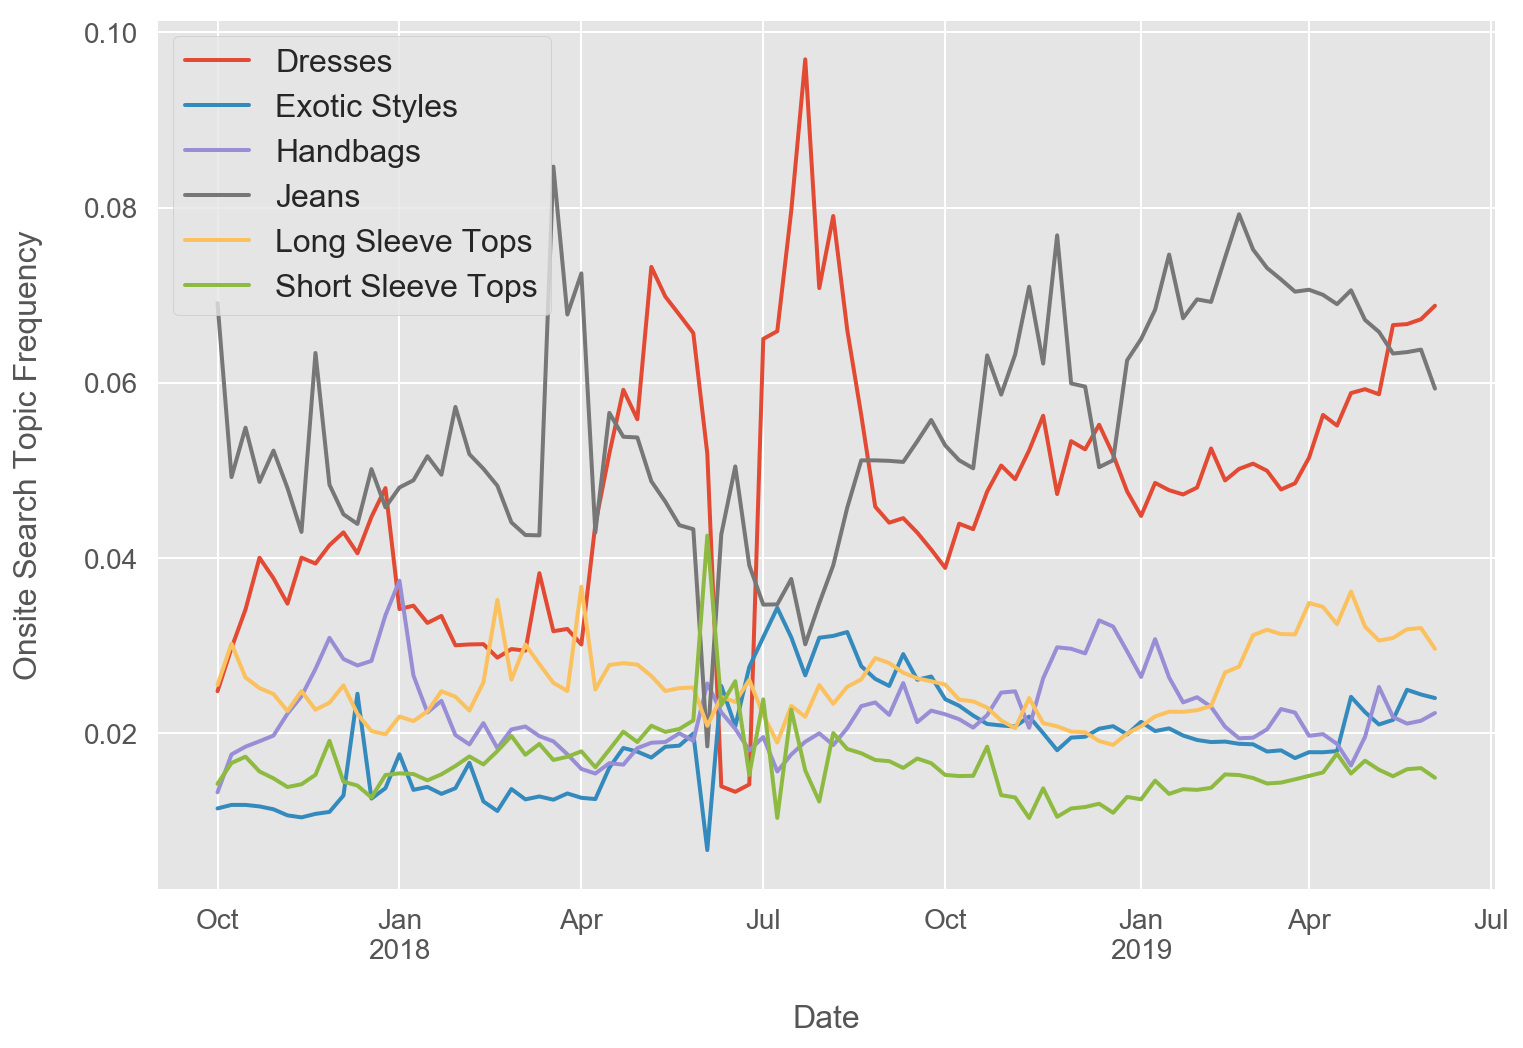

In [191]:
plot_trends(
    df_search_terms,
    topic_names,
);

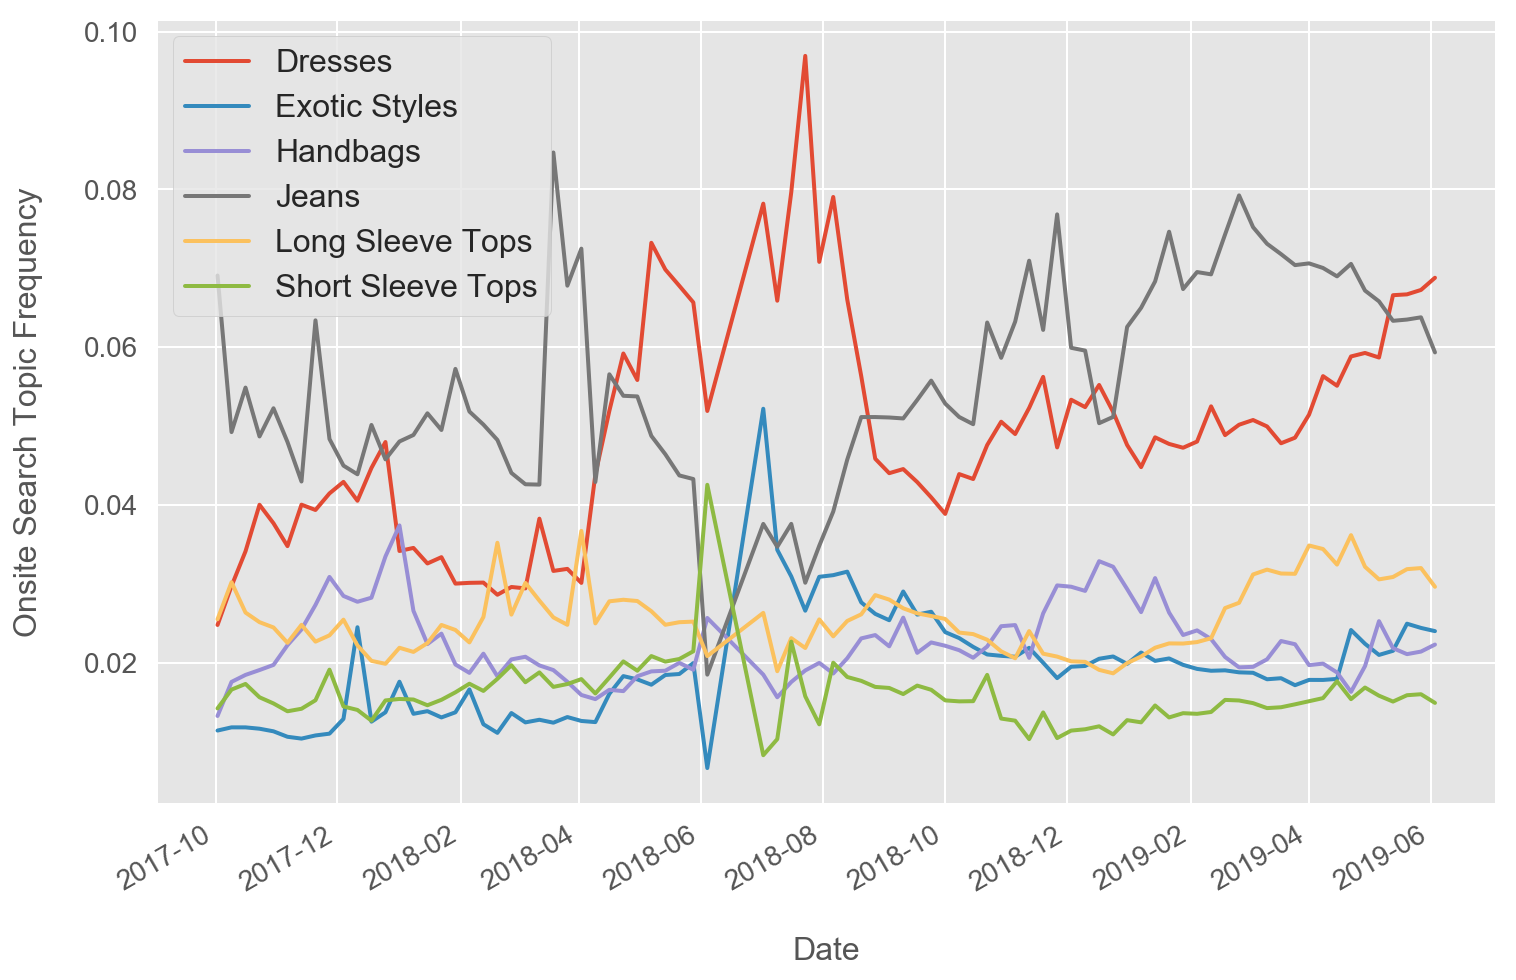

In [192]:
m = (df_search_terms.date < '2018-06-01') | (df_search_terms.date > '2018-07-01')
df_topic_freq = plot_trends(
    df_search_terms[m],
    topic_names,
)

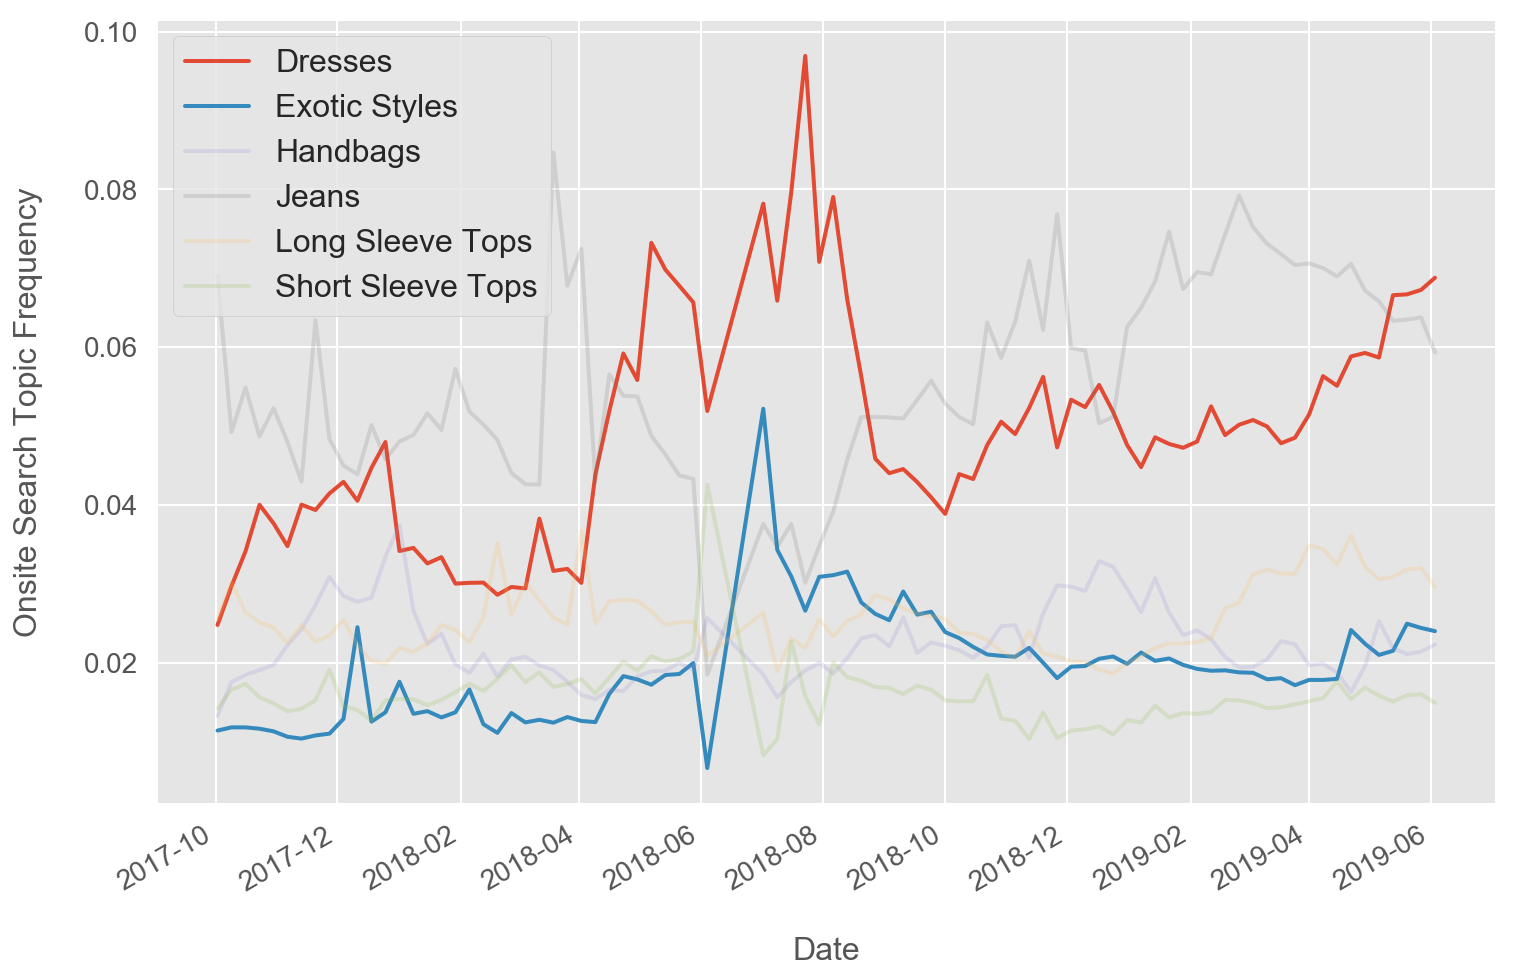

In [194]:
m = (df_search_terms.date < '2018-06-01') | (df_search_terms.date > '2018-07-01')
df_topic_freq = plot_trends(
    df_search_terms[m],
    topic_names,
    output_name='onsite_search_topic_relative_trends_filter_1',
    filter_on_topics=['Dresses', 'Exotic Styles'],
)

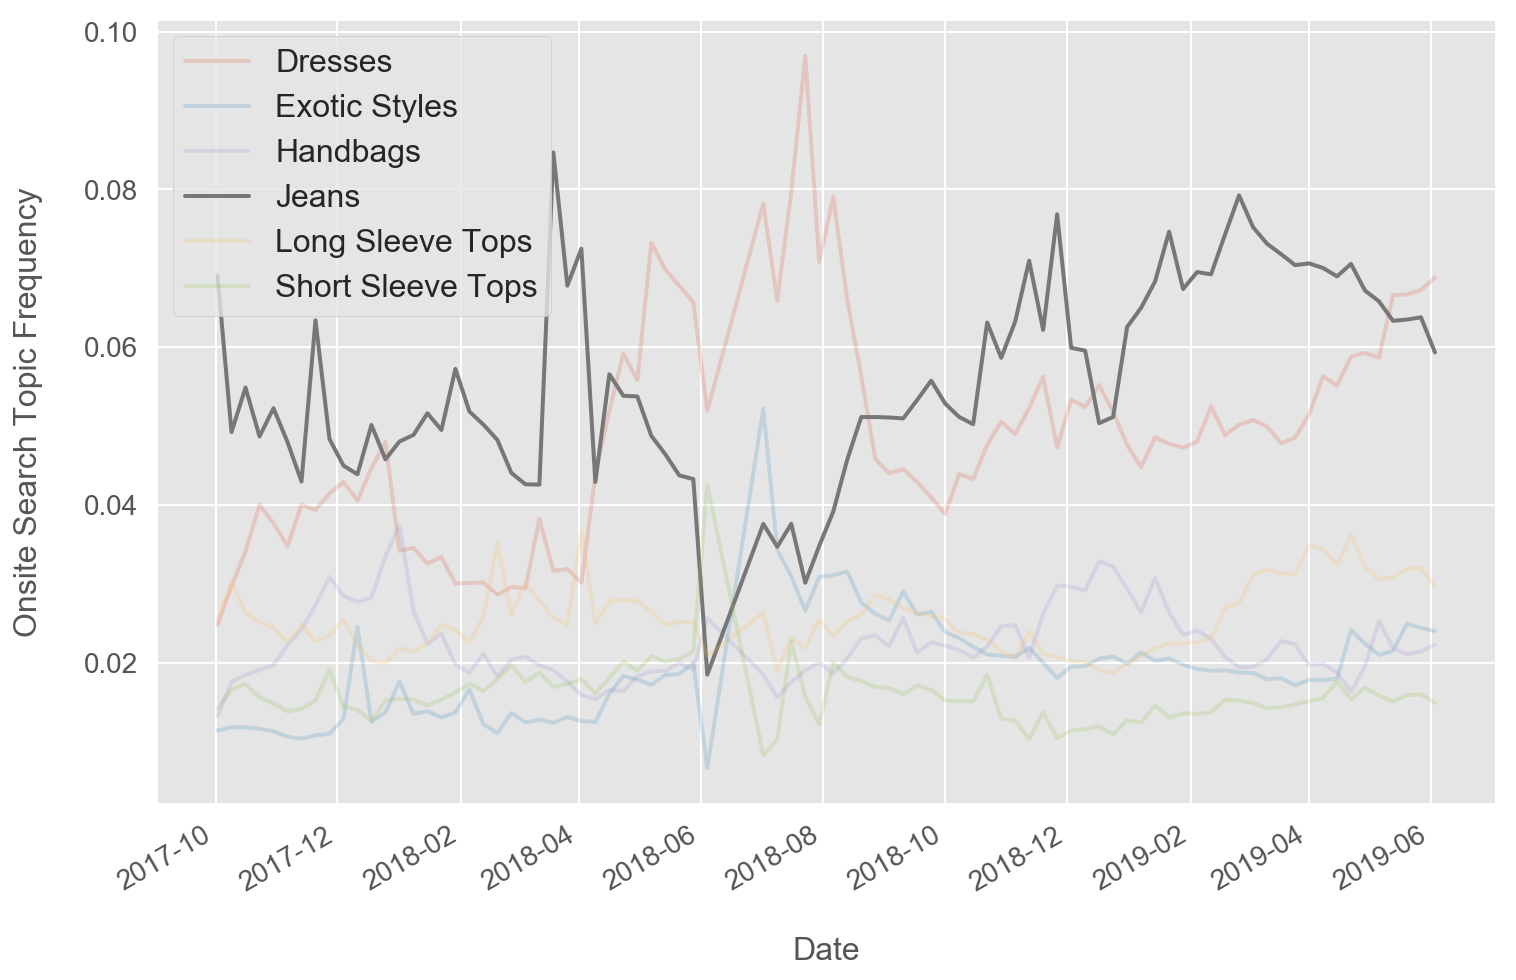

In [195]:
m = (df_search_terms.date < '2018-06-01') | (df_search_terms.date > '2018-07-01')
df_topic_freq = plot_trends(
    df_search_terms[m],
    topic_names,
    output_name='onsite_search_topic_relative_trends_filter_2',
    filter_on_topics=['Jeans'],
)

No output name, not saving fig


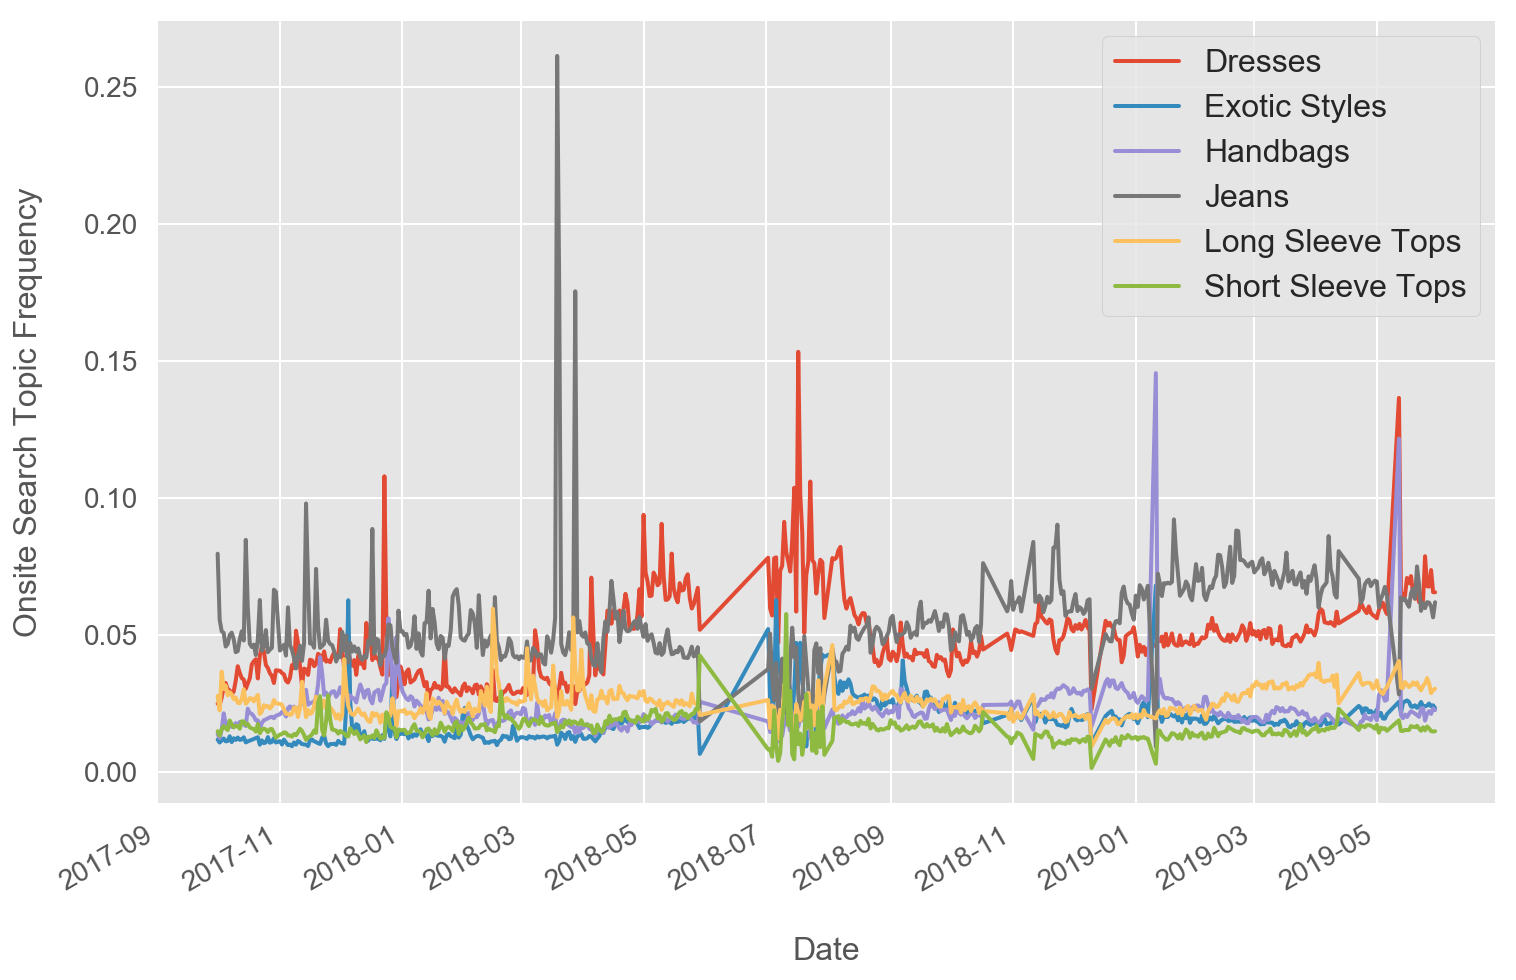

In [176]:
m = (df_search_terms.date < '2018-06-01') | (df_search_terms.date > '2018-07-01')

df_topic_freq = plot_trends(
    df_search_terms[m],
    topic_names,
    output_name='',
    groupby='day',
)

df_topic_freq_daily = df_topic_freq.reset_index().melt(
    id_vars=['date'],
    value_vars=df_topic_freq.columns.tolist()
).rename(columns={'variable': 'topic', 'value': 'num_searches'})

In [177]:
df_topic_freq_daily.sample(5)

date             topic  num_searches
1436 2018-05-11          Handbags      0.019945
2849 2018-11-26  Long Sleeve Tops      0.020064
988  2018-10-17     Exotic Styles      0.017832
2868 2018-12-15  Long Sleeve Tops           NaN
4    2017-10-05           Dresses      0.032539

No output name, not saving fig


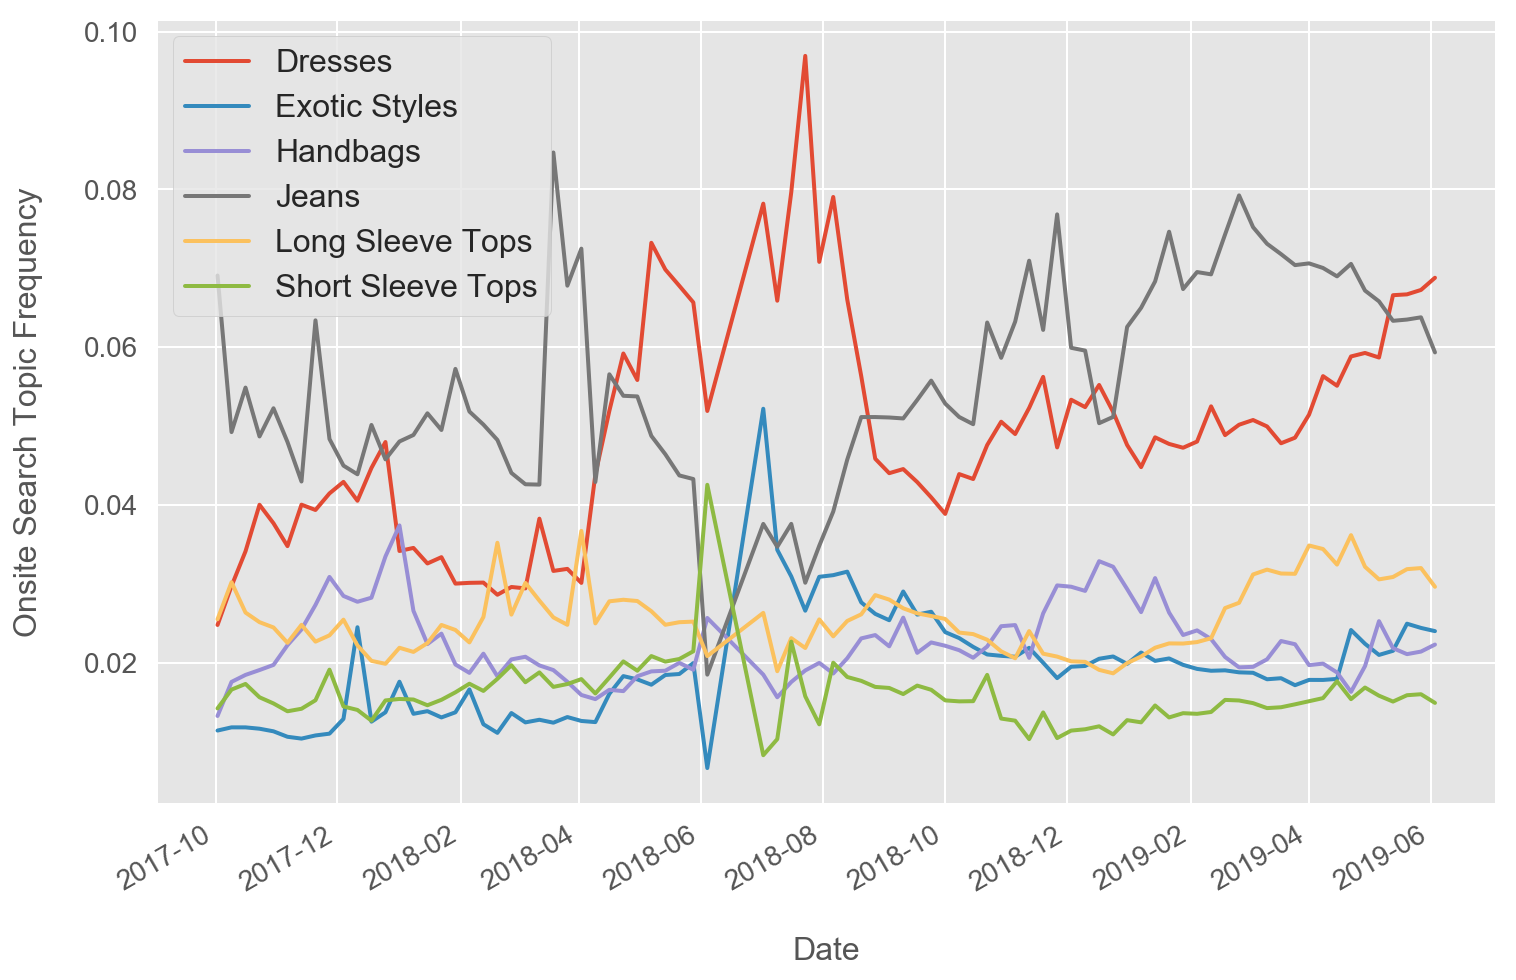

In [178]:
m = (df_search_terms.date < '2018-06-01') | (df_search_terms.date > '2018-07-01')

df_topic_freq = plot_trends(
    df_search_terms[m],
    topic_names,
    output_name='',
    groupby='week',
)

df_topic_freq_weekly = df_topic_freq.reset_index().melt(
    id_vars=['date'],
    value_vars=df_topic_freq.columns.tolist()
).rename(columns={'variable': 'topic', 'value': 'num_searches'})

In [179]:
df_topic_freq_weekly.sample(5)

date              topic  num_searches
350 2019-05-27              Jeans      0.063792
519 2019-04-08  Short Sleeve Tops      0.015533
220 2018-08-06           Handbags      0.018655
427 2019-03-11   Long Sleeve Tops      0.031818
521 2019-04-22  Short Sleeve Tops      0.015404

No output name, not saving fig


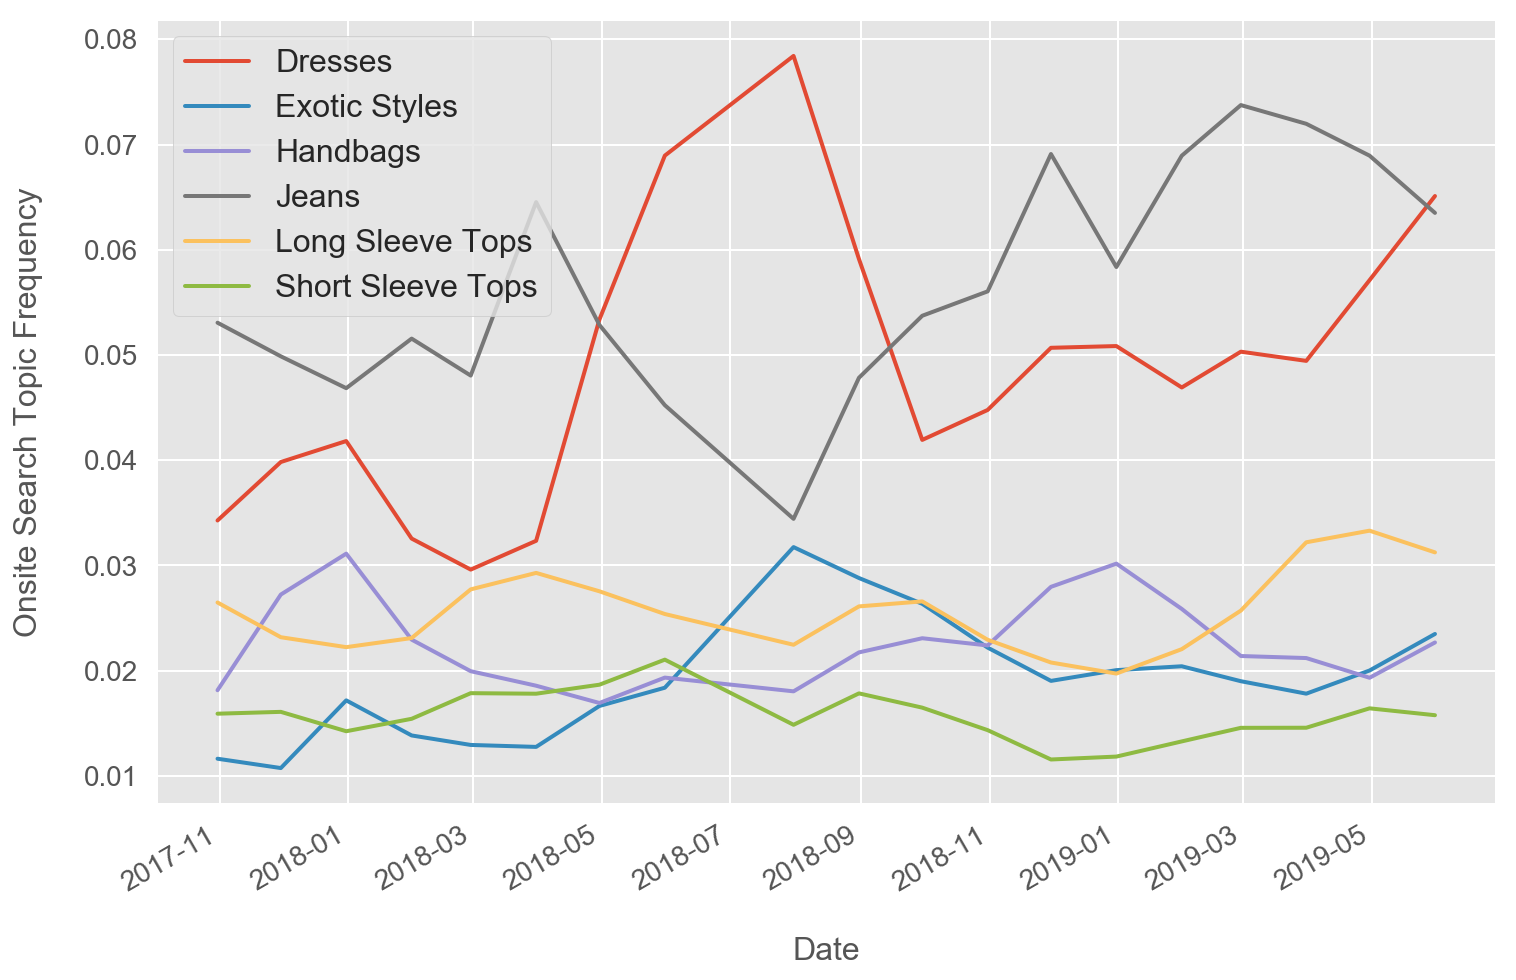

In [180]:
m = (df_search_terms.date < '2018-06-01') | (df_search_terms.date > '2018-07-01')

df_topic_freq = plot_trends(
    df_search_terms[m],
    topic_names,
    output_name='',
    groupby='month',
)

df_topic_freq_monthly = df_topic_freq.reset_index().melt(
    id_vars=['date'],
    value_vars=df_topic_freq.columns.tolist()
).rename(columns={'variable': 'topic', 'value': 'num_searches'})

In [181]:
df_topic_freq_monthly.sample(5)

date              topic  num_searches
6   2018-04-30            Dresses      0.053372
50  2018-08-31           Handbags      0.021740
102 2017-12-31  Short Sleeve Tops      0.014248
110 2018-08-31  Short Sleeve Tops      0.017845
39  2019-05-31      Exotic Styles      0.023492

### Modeling trend frequency

In [148]:
from fbprophet import Prophet
import warnings
# Ignore warnings from prophet lib
warnings.filterwarnings('ignore', 'Conversion of the second argument of issubdtype')

In [168]:
def build_prophet_df(df, segment_col, value_col='num_searches', date_col='date'):
    df_prophet = (
        df.groupby([date_col, segment_col])[value_col].sum()
        .reset_index()
        .rename(columns={value_col: 'y'})
    )
    df_prophet['ds'] = df_prophet[date_col].apply(lambda x: x.strftime('%Y-%m-%d'))
    df_prophet = df_prophet.sort_values(date_col, ascending=True)
    return df_prophet

def segment_forecast(
    df,
    segment_col,
    groupby='day',
    segments=None,
    max_num_segments=6,
    daily_seasonality=False,
    weekly_seasonality=2,
    yearly_seasonality=10,
    seasonality_prior_scale=0.1,
    y_label='Search Frequency',
    plot_trends=True,
):
    if groupby not in (('day', 'week', 'month')):
        raise ValueError('Bad value for groupby ({})'.format(groupby))
        
    elif groupby == 'day':
        freq = 'D'
        periods = 365
        
    elif groupby == 'week':
        freq = '7D'
        periods = 52
        
    elif groupby == 'month':
        freq = 'M'        
        periods = 12
    
    df_prophet = build_prophet_df(df, segment_col)
    
    # Get top segments (by sum of target variable)
    if not segments:
        segments = (
            df_prophet.groupby(segment_col)['y'].sum()
            .sort_values(ascending=False)
            .head(max_num_segments).index.tolist()
        )
    models = []
    forecasts = []
    for seg in segments:
        m = Prophet(
            daily_seasonality=daily_seasonality,
            weekly_seasonality=weekly_seasonality,
            yearly_seasonality=yearly_seasonality,
            seasonality_prior_scale=seasonality_prior_scale,
        )
        m.fit(df_prophet[df_prophet[segment_col] == seg])
        models.append(m)
        
        future = m.make_future_dataframe(periods=periods, freq=freq)
        forecast = m.predict(future)
        forecasts.append(forecast)
        
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10 * 10
    fig, axes = plt.subplots(len(forecasts), sharex=True)
    for i, (ax, seg, forecast, c) in enumerate(zip(axes, segments, forecasts, colors)):
        forecast.set_index('ds')['yhat'].plot(label=seg, ax=ax, color=c)
        (df_prophet[df_prophet[segment_col] == seg]
         .set_index('date')['y'].plot(label='_', ax=ax, color=c, marker='o', linewidth=0))
        ax.legend()
        if i == int(len(forecasts) / 2):
            ax.set_ylabel(y_label)
        else:
            ax.set_ylabel('')

    plt.xlabel('')
    savefig('onsite_search_{}_{}_forecast'.format(
        '-'.join(segment_col.split(' ')),
        groupby,
    ))
    plt.show()

    if plot_trends:
        for seg, m, forecast, c in zip(segments, models, forecasts, colors):
            fig = m.plot_components(forecast)
            
            fig.axes[0].set_xlabel('{} - Date'.format(seg.title()))
            fig.axes[0].set_ylabel('Overall Trend')
            fig.axes[0].lines[0].set_color(c)
            
            fig.axes[1].set_xlabel('{} - Day of Week'.format(seg.title()))
            fig.axes[1].set_ylabel('Weekly Trend')
            fig.axes[1].lines[0].set_color(c)
            
            fig.axes[2].set_xlabel('{} - Day of Year'.format(seg.title()))
            fig.axes[2].set_ylabel('Yearly Trend')
            fig.axes[2].lines[0].set_color(c)
    
            savefig('onsite_search_{}={}_{}_forecast_trends'.format(
                '-'.join(segment_col.split(' ')),
                '-'.join(seg.split(' ')),
                groupby,
            ))
            plt.show()

In [169]:
df_topic_freq_daily.sample(5)

date          topic  num_searches
2320 2019-02-12          Jeans      0.079122
406  2018-11-11        Dresses      0.049712
1871 2017-11-20          Jeans      0.053297
493  2019-02-06        Dresses      0.053821
707  2018-01-09  Exotic Styles      0.014329

Warning, padding values (avoid this in the future)


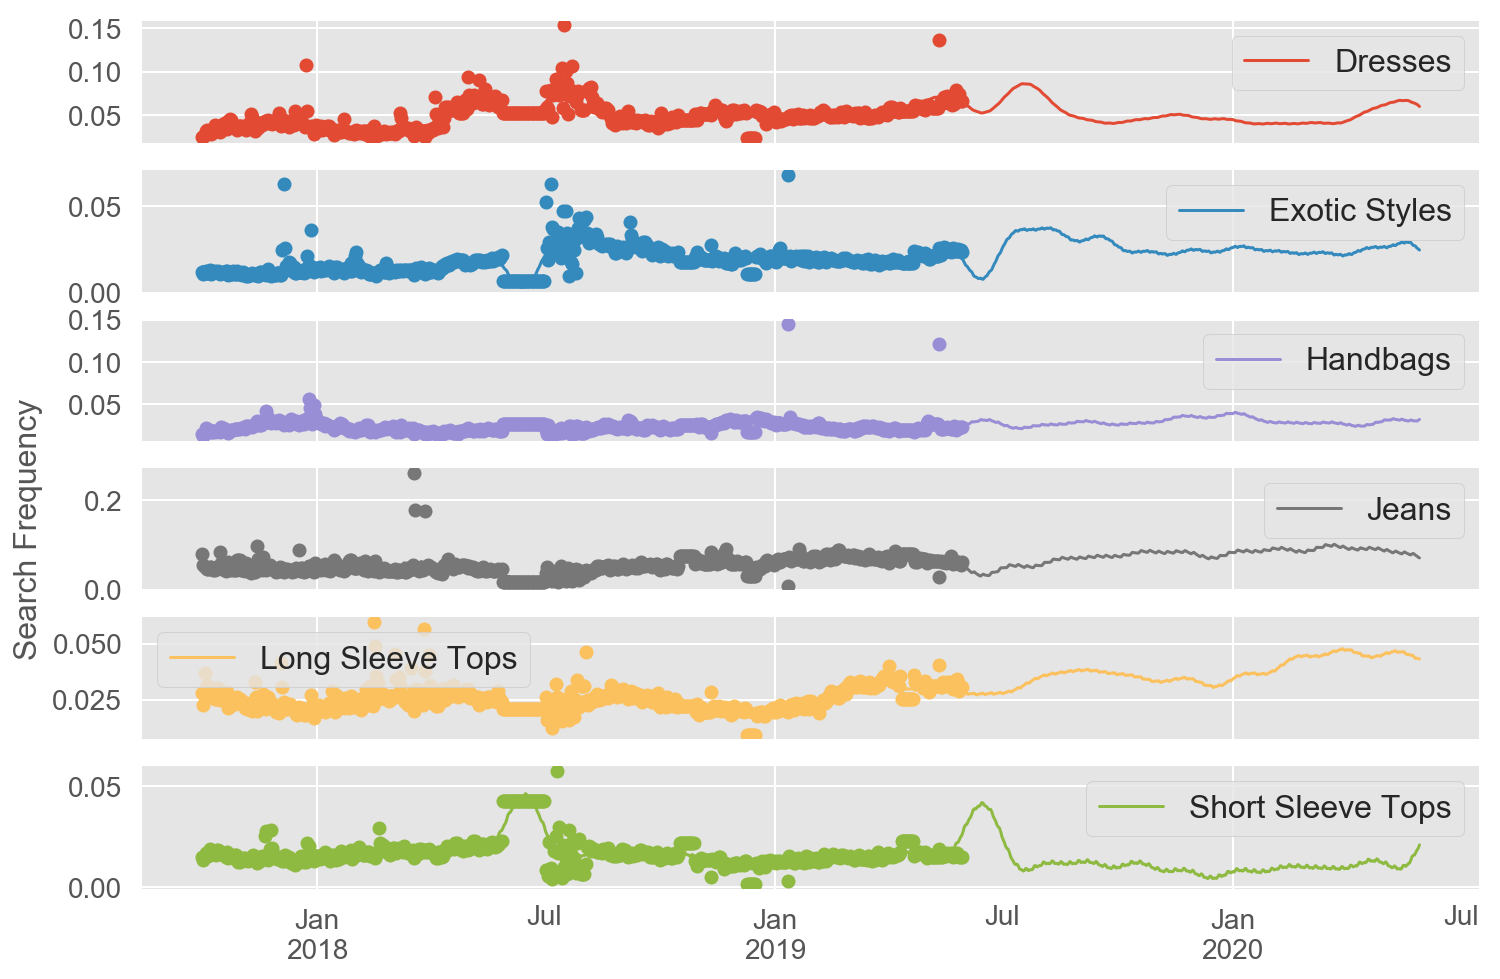

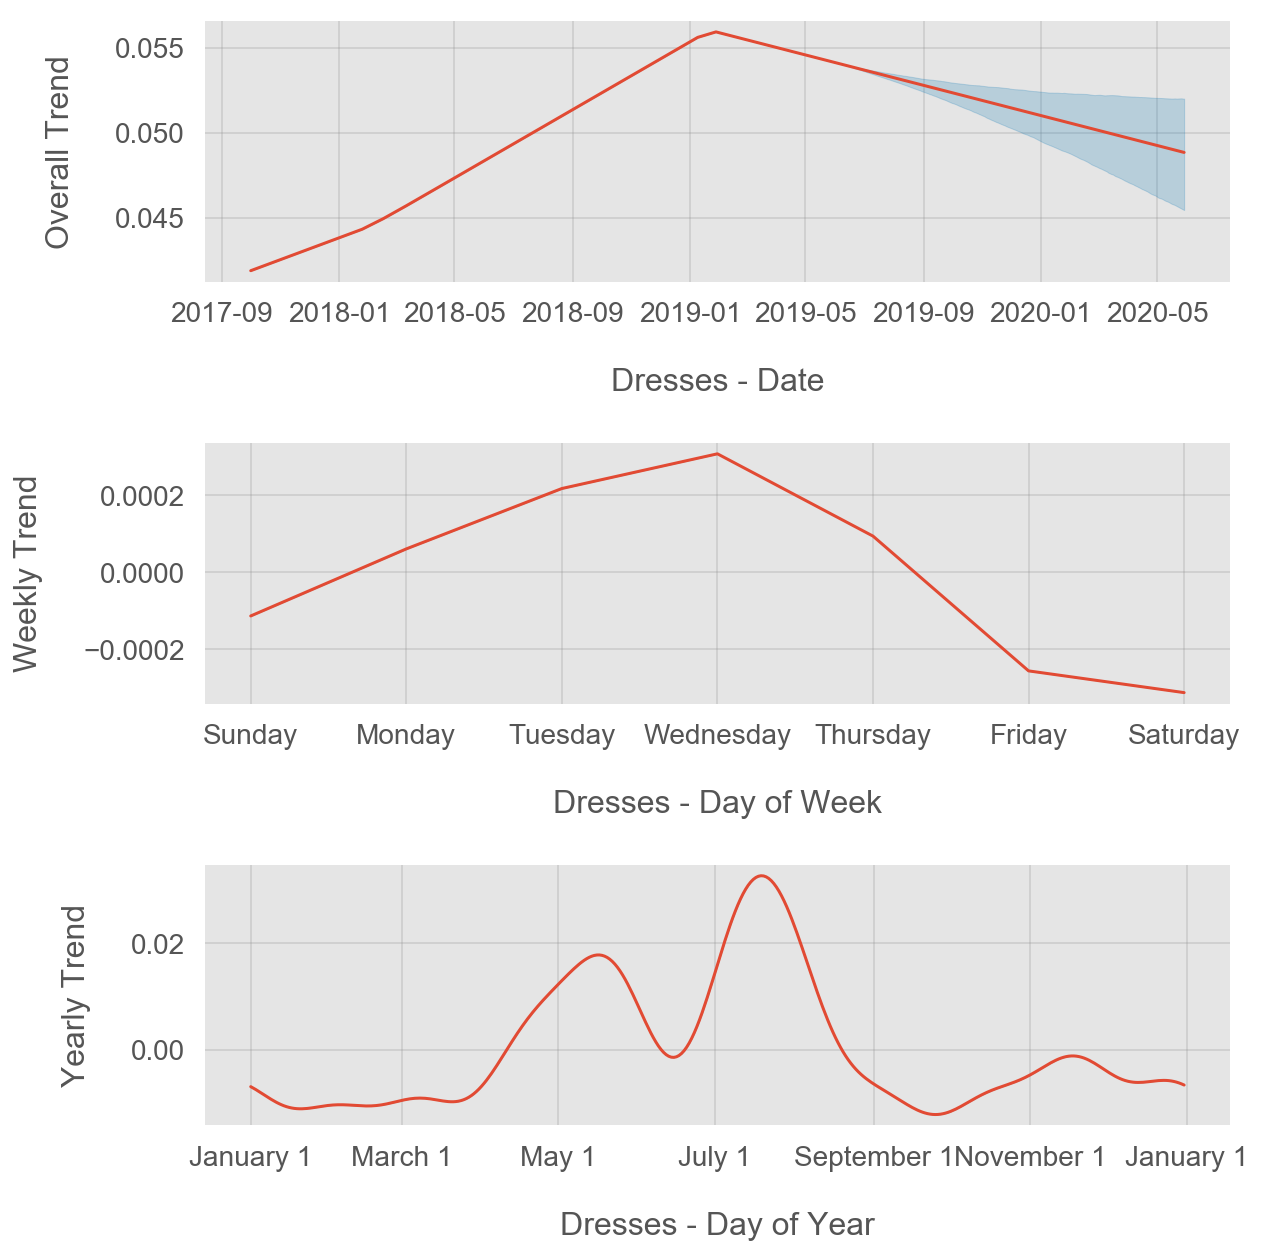

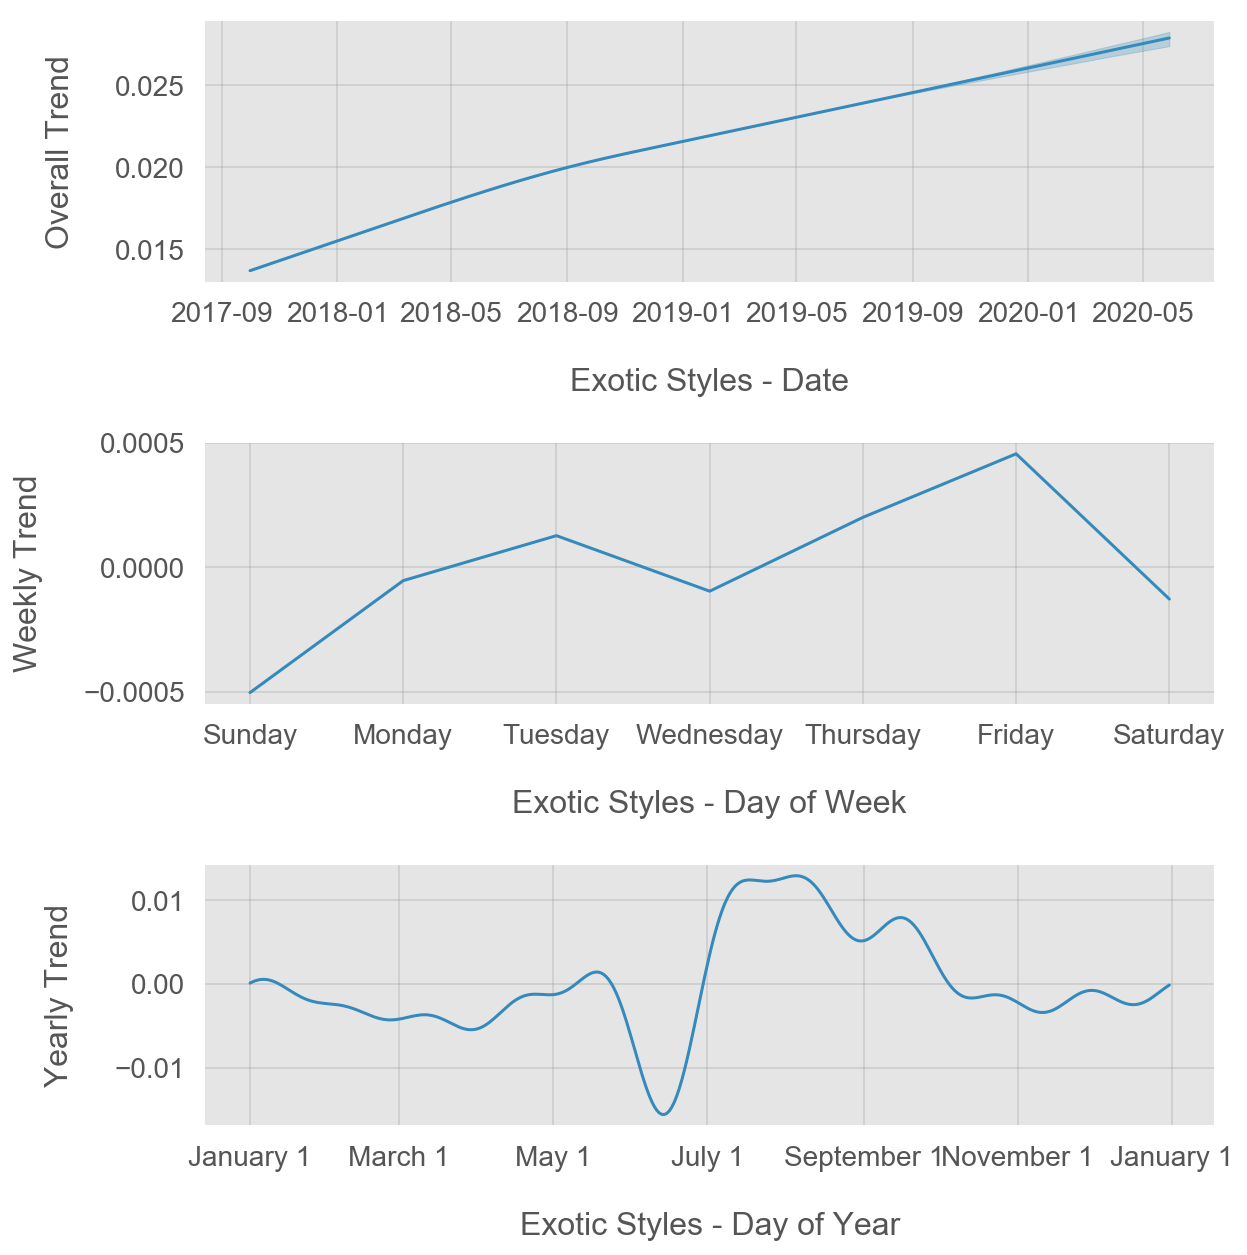

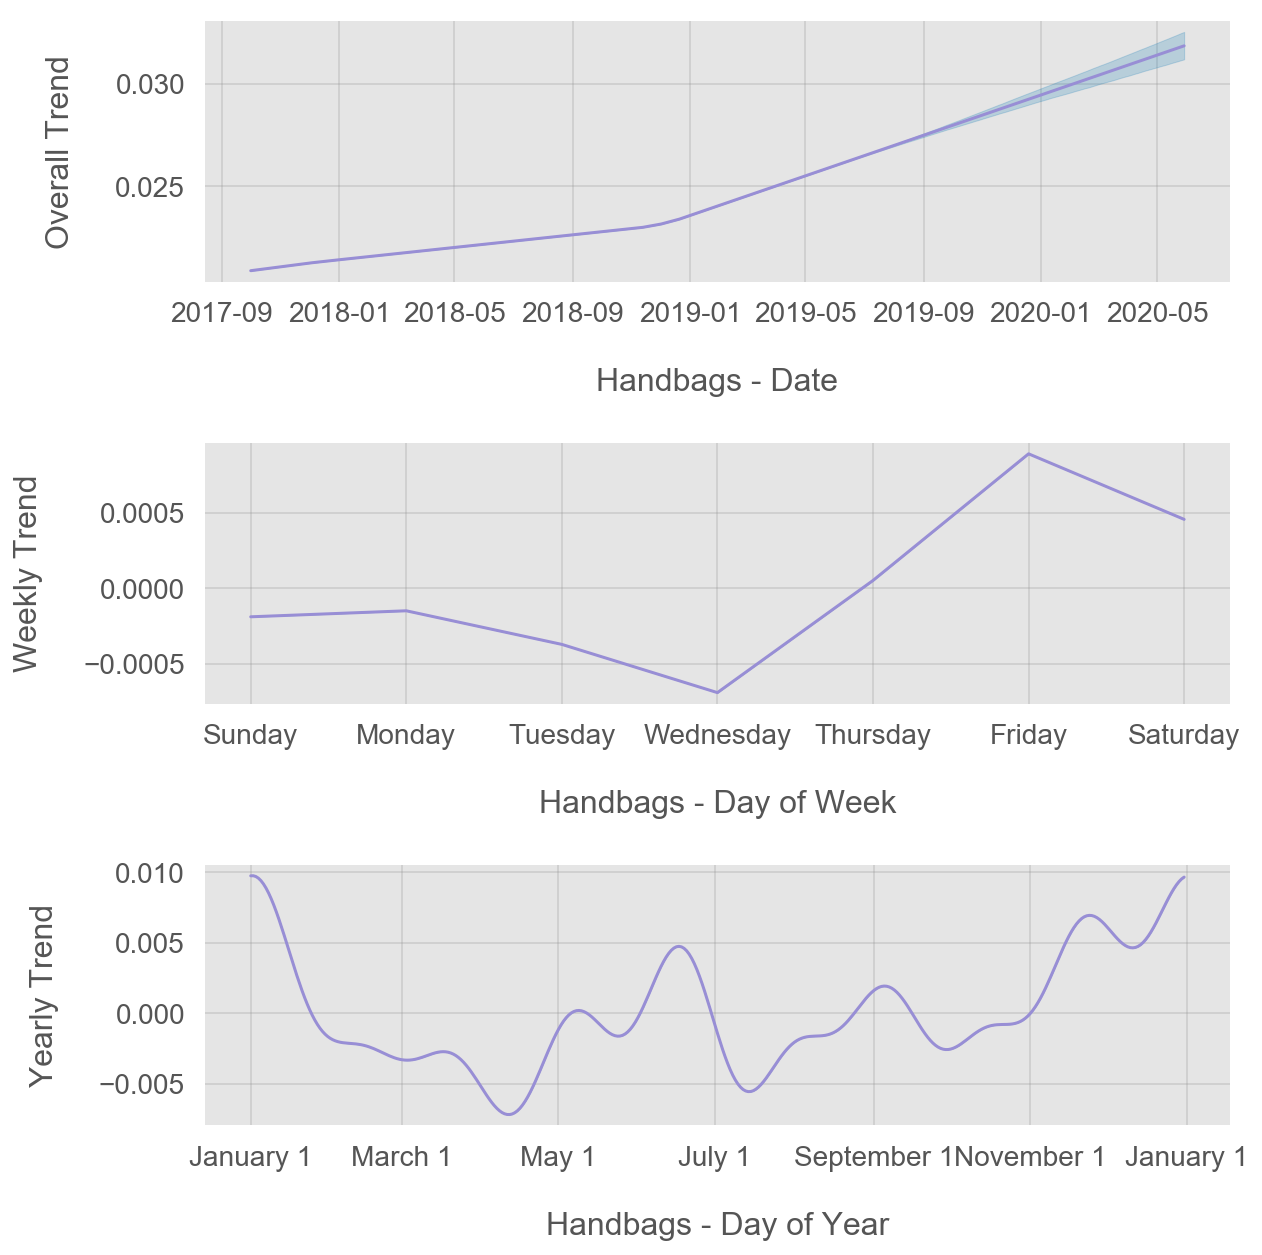

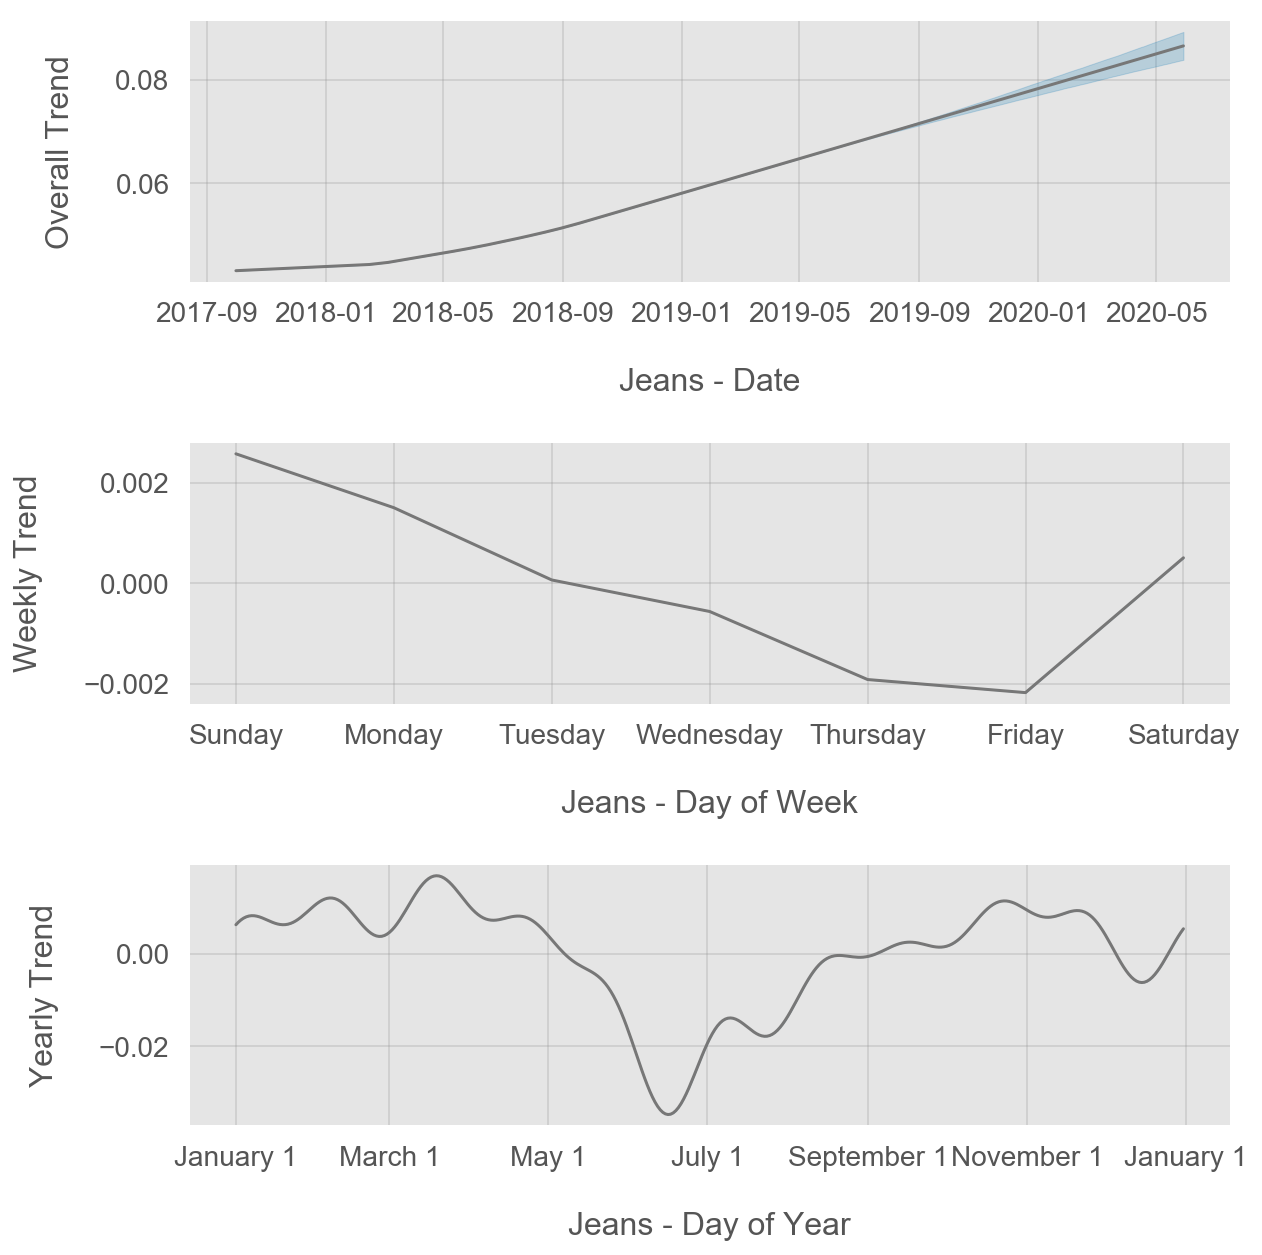

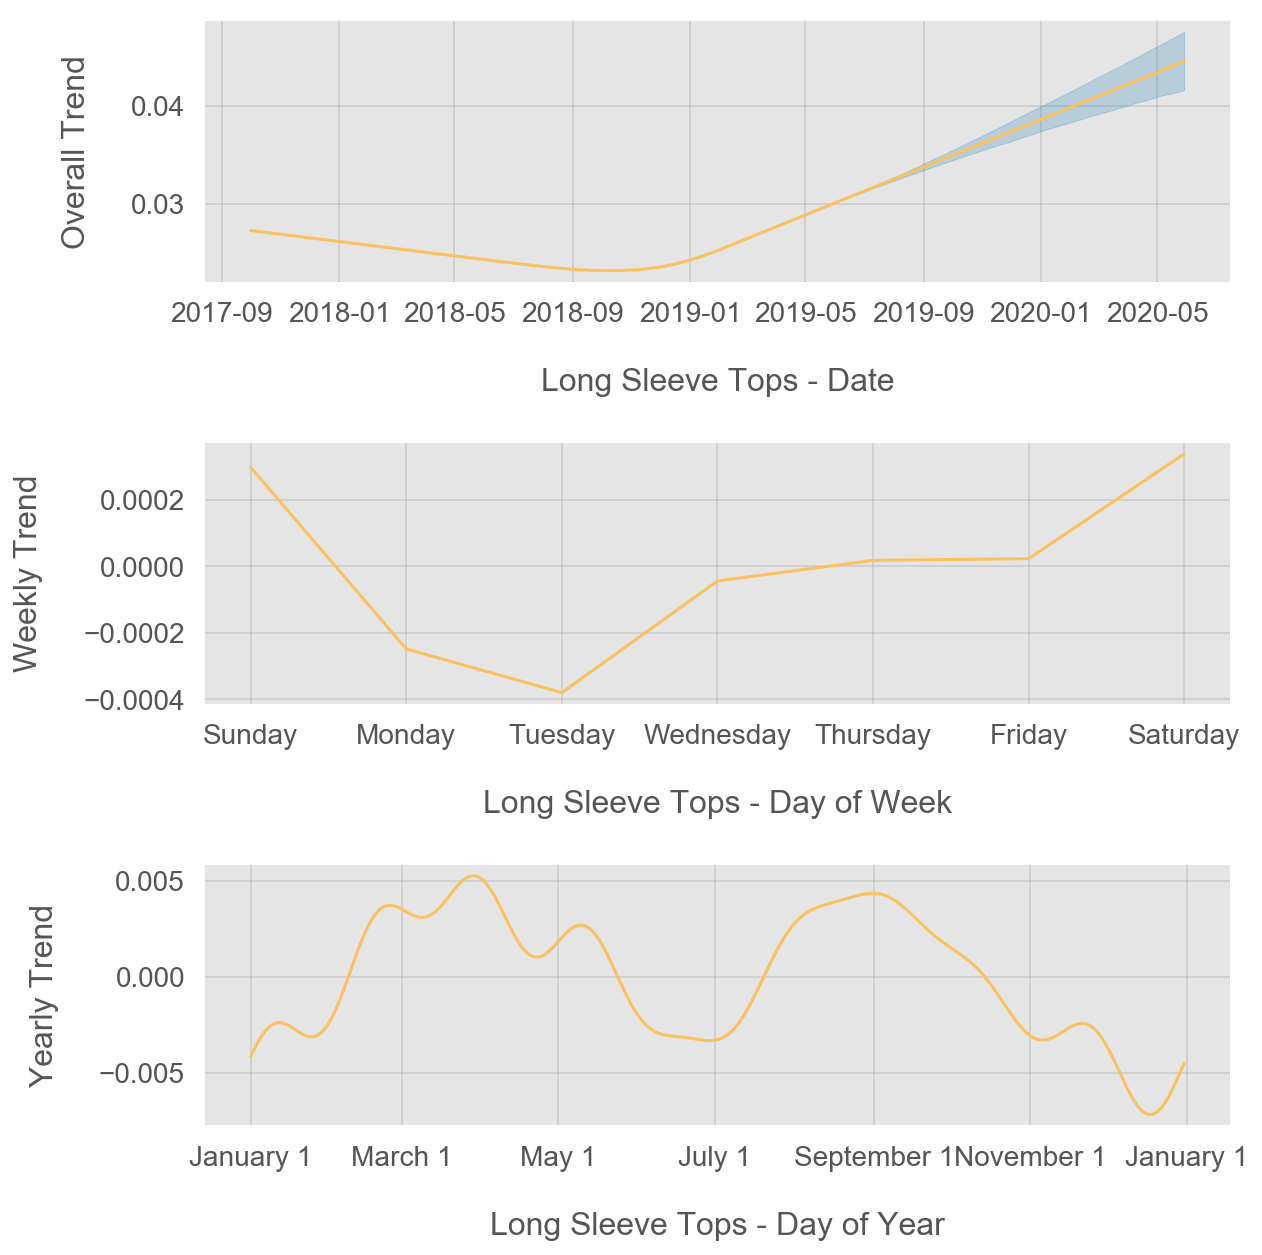

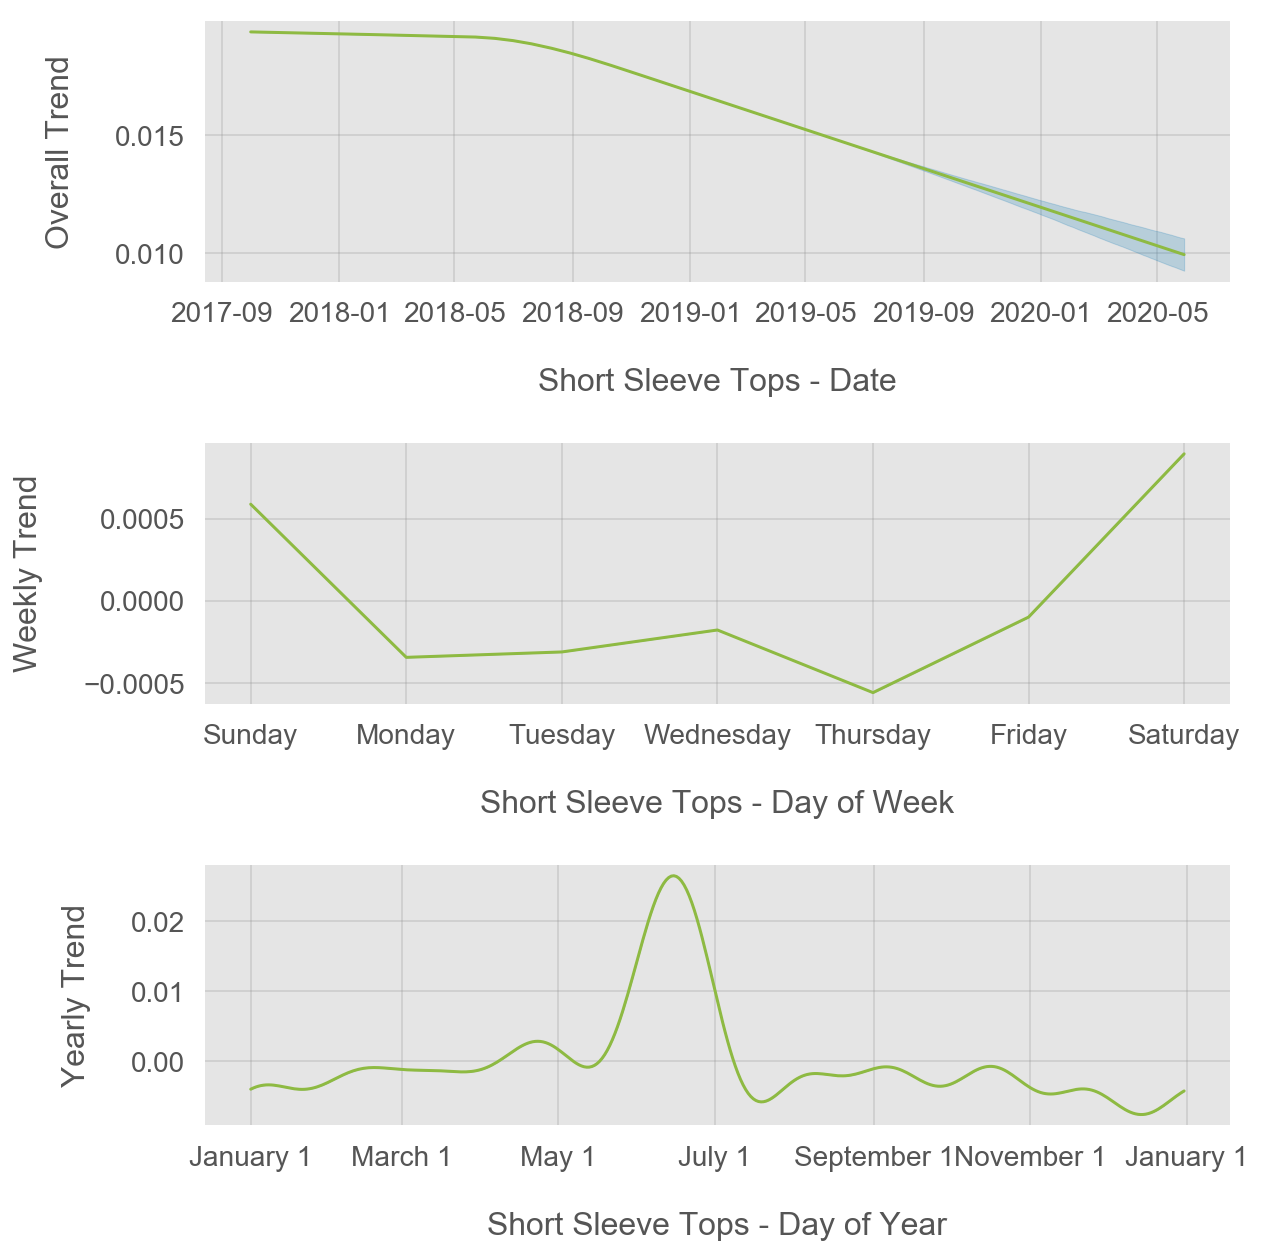

In [170]:
print('Warning, padding values (avoid this in the future)')
segment_forecast(
    df_topic_freq_daily.fillna(method='pad'),
    segment_col='topic',
    groupby='day',
    segments=topic_names,
)

Warning, padding values (avoid this in the future)


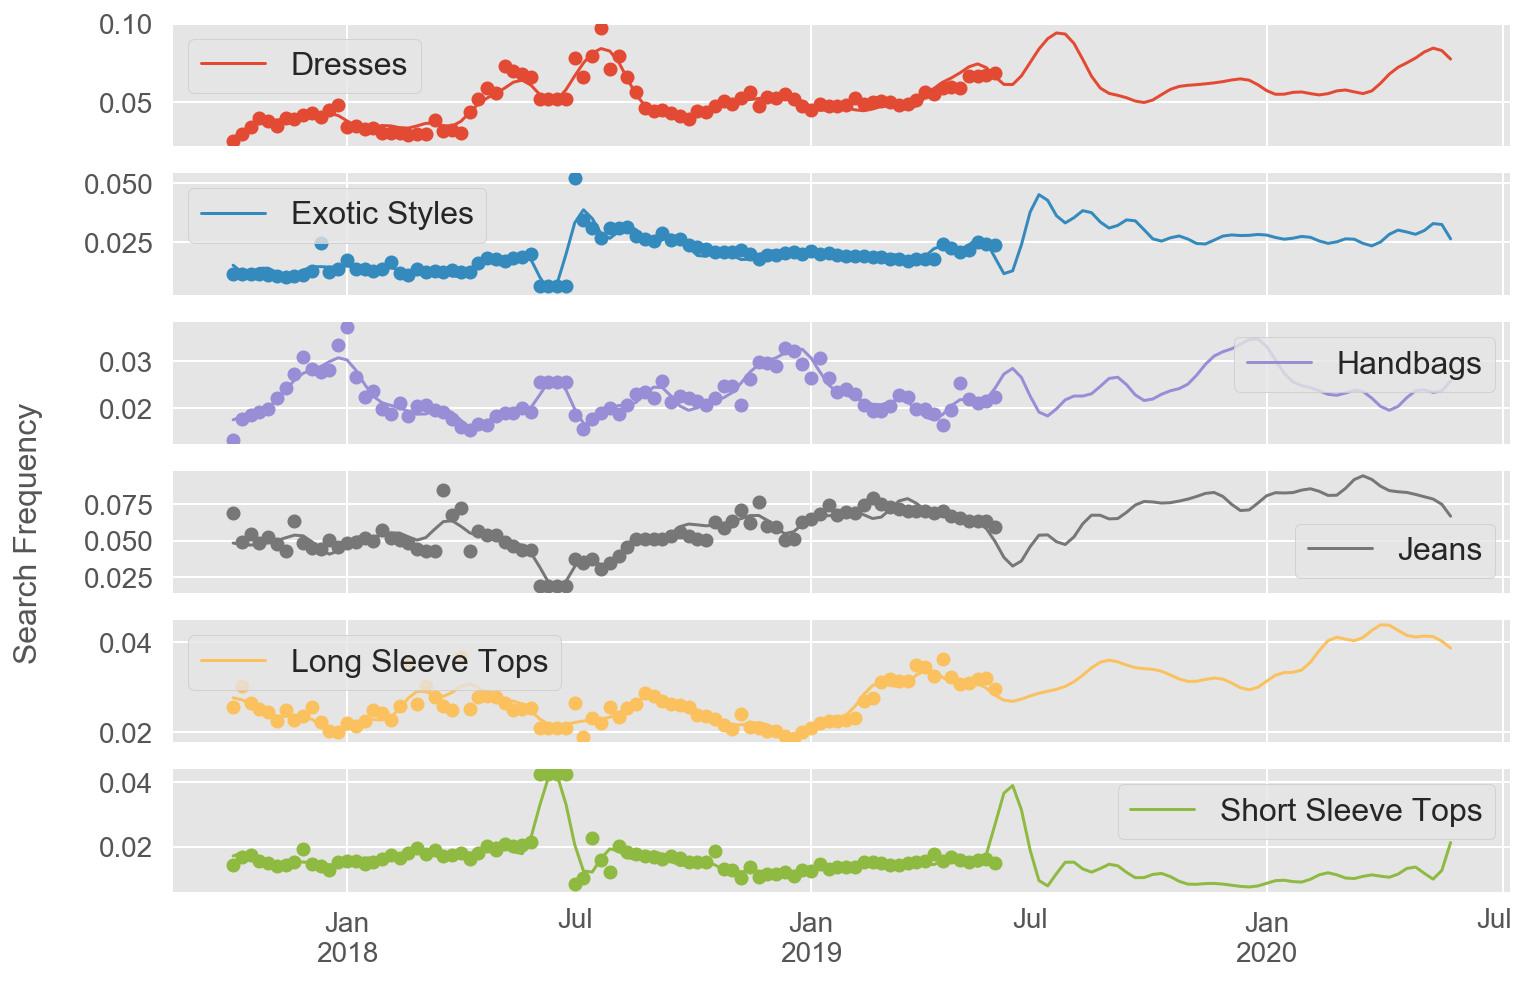

In [171]:
print('Warning, padding values (avoid this in the future)')
segment_forecast(
    df_topic_freq_weekly.fillna(method='pad'),
    segment_col='topic',
    groupby='week',
    segments=topic_names,
    plot_trends=False,
)

Warning, padding values (avoid this in the future)


INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.
/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:347: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.
/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:347: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.
/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:347: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.
/ana

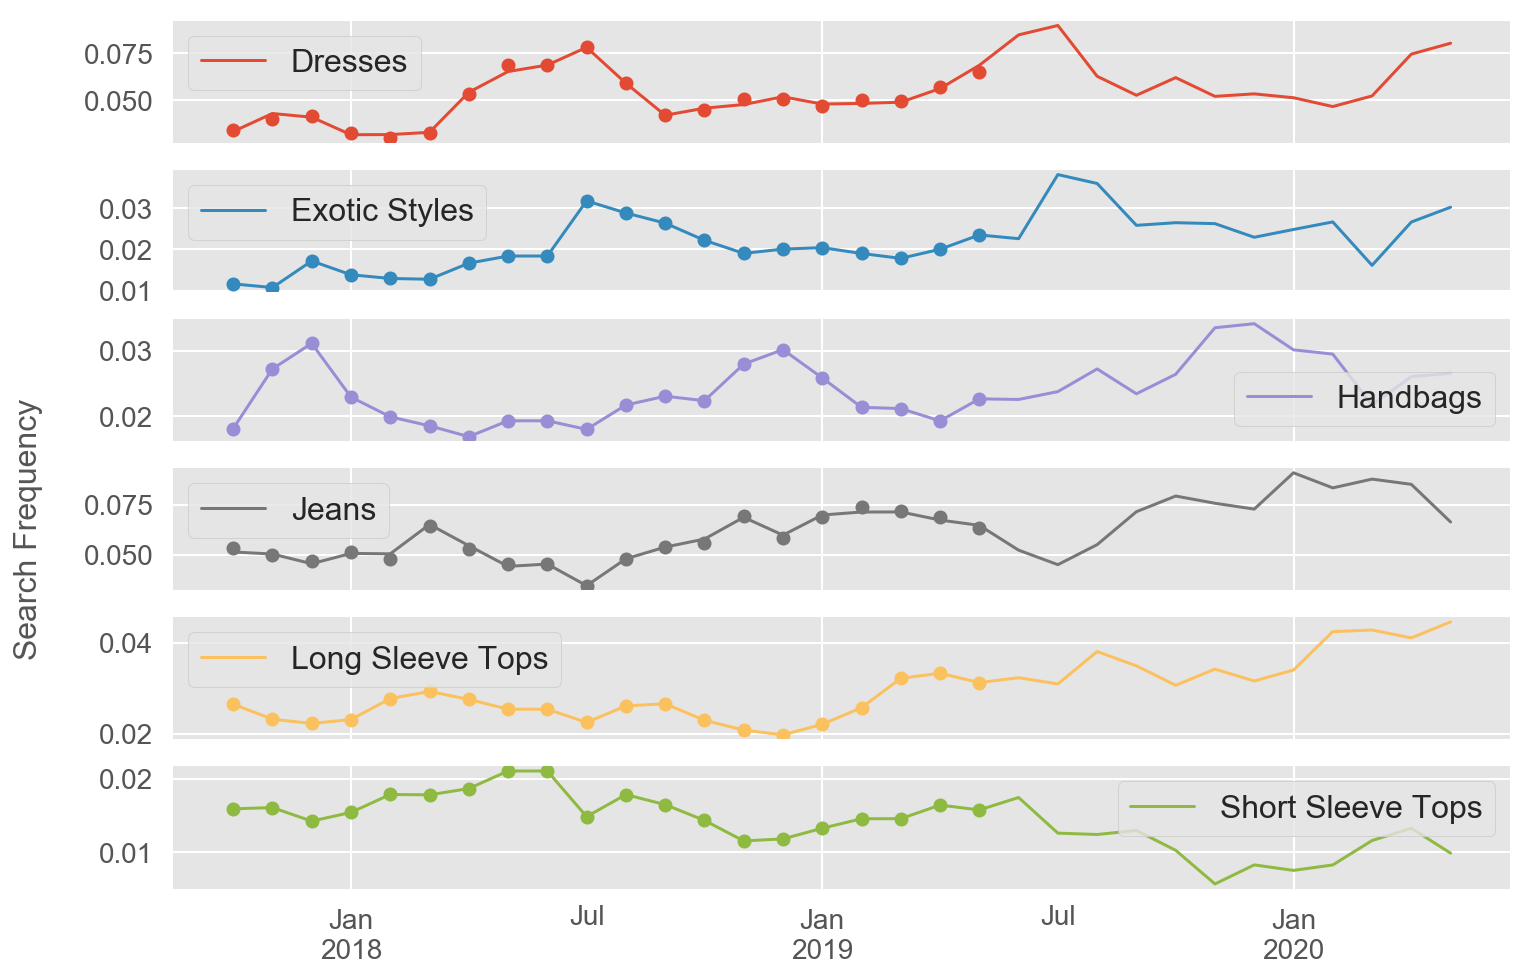

In [172]:
print('Warning, padding values (avoid this in the future)')
segment_forecast(
    df_topic_freq_monthly.fillna(method='pad'),
    segment_col='topic',
    groupby='month',
    segments=topic_names,
    plot_trends=False,
)

**How can this be applied?**

- Use trend patterns (seasonal and non-seasonal) to inform marketing strategy.
- Label users (realtime) who use onsite search. Curate experience (e.g. banner ads, recommended items) based on topic grouping.

**Similar research ideas**

- Apply topic labels to sessions and train predictive model on many features (e.g. region, browser, source, pages per session, etc...). Use interpretation library like [Lime](https://github.com/marcotcr/lime) to understand these user groups better.
- In a semi-structured approach, manually label a set of onsite searches (e.g. 1k rows), train model and apply predictions to remaining dataset. Pros: topic groups are easier to interpret. Cons: time spent labelling data, must be careful to spotcheck results.

### Compare with Google Trends

In [197]:
trends_data = [row.split('\t') for row in '''
Week	long sleeve tops: (United States)	short sleeve tops: (United States)
2014-06-22	14	20
2014-06-29	19	11
2014-07-06	17	10
2014-07-13	26	14
2014-07-20	21	13
2014-07-27	17	13
2014-08-03	22	8
2014-08-10	23	14
2014-08-17	35	10
2014-08-24	26	6
2014-08-31	25	11
2014-09-07	24	6
2014-09-14	31	7
2014-09-21	42	7
2014-09-28	41	8
2014-10-05	36	7
2014-10-12	47	7
2014-10-19	45	11
2014-10-26	48	8
2014-11-02	49	5
2014-11-09	41	7
2014-11-16	51	5
2014-11-23	53	12
2014-11-30	39	10
2014-12-07	47	9
2014-12-14	42	9
2014-12-21	31	6
2014-12-28	30	11
2015-01-04	31	5
2015-01-11	30	7
2015-01-18	35	12
2015-01-25	29	8
2015-02-01	25	11
2015-02-08	34	13
2015-02-15	38	12
2015-02-22	32	11
2015-03-01	20	17
2015-03-08	27	15
2015-03-15	26	21
2015-03-22	17	17
2015-03-29	19	12
2015-04-05	21	19
2015-04-12	25	20
2015-04-19	23	17
2015-04-26	14	10
2015-05-03	26	18
2015-05-10	25	23
2015-05-17	27	11
2015-05-24	36	19
2015-05-31	18	23
2015-06-07	15	19
2015-06-14	24	14
2015-06-21	17	18
2015-06-28	15	16
2015-07-05	18	13
2015-07-12	18	13
2015-07-19	23	18
2015-07-26	20	19
2015-08-02	25	4
2015-08-09	23	9
2015-08-16	35	15
2015-08-23	31	9
2015-08-30	40	12
2015-09-06	29	11
2015-09-13	40	13
2015-09-20	34	10
2015-09-27	56	14
2015-10-04	55	8
2015-10-11	46	7
2015-10-18	58	9
2015-10-25	35	10
2015-11-01	42	10
2015-11-08	46	6
2015-11-15	45	7
2015-11-22	42	11
2015-11-29	54	12
2015-12-06	51	12
2015-12-13	39	10
2015-12-20	24	7
2015-12-27	50	12
2016-01-03	36	13
2016-01-10	35	14
2016-01-17	63	6
2016-01-24	51	5
2016-01-31	45	17
2016-02-07	53	21
2016-02-14	33	23
2016-02-21	31	24
2016-02-28	42	20
2016-03-06	31	35
2016-03-13	38	24
2016-03-20	36	17
2016-03-27	36	23
2016-04-03	34	25
2016-04-10	28	34
2016-04-17	39	31
2016-04-24	34	23
2016-05-01	34	19
2016-05-08	27	34
2016-05-15	42	20
2016-05-22	35	26
2016-05-29	38	33
2016-06-05	30	28
2016-06-12	35	30
2016-06-19	32	18
2016-06-26	33	22
2016-07-03	29	28
2016-07-10	36	18
2016-07-17	29	19
2016-07-24	26	24
2016-07-31	49	20
2016-08-07	37	16
2016-08-14	36	22
2016-08-21	35	10
2016-08-28	47	15
2016-09-04	47	11
2016-09-11	55	16
2016-09-18	45	14
2016-09-25	57	17
2016-10-02	64	13
2016-10-09	69	17
2016-10-16	63	12
2016-10-23	76	7
2016-10-30	56	9
2016-11-06	63	9
2016-11-13	62	7
2016-11-20	78	20
2016-11-27	79	13
2016-12-04	54	18
2016-12-11	58	9
2016-12-18	53	11
2016-12-25	64	10
2017-01-01	50	12
2017-01-08	49	6
2017-01-15	63	16
2017-01-22	44	13
2017-01-29	51	25
2017-02-05	52	20
2017-02-12	49	23
2017-02-19	47	19
2017-02-26	44	22
2017-03-05	46	20
2017-03-12	47	24
2017-03-19	49	23
2017-03-26	45	35
2017-04-02	47	30
2017-04-09	43	29
2017-04-16	39	32
2017-04-23	46	27
2017-04-30	43	25
2017-05-07	48	15
2017-05-14	40	19
2017-05-21	26	24
2017-05-28	39	23
2017-06-04	47	24
2017-06-11	33	26
2017-06-18	29	25
2017-06-25	41	24
2017-07-02	38	19
2017-07-09	63	23
2017-07-16	45	19
2017-07-23	68	22
2017-07-30	47	18
2017-08-06	52	18
2017-08-13	44	19
2017-08-20	54	16
2017-08-27	51	23
2017-09-03	66	19
2017-09-10	78	20
2017-09-17	61	18
2017-09-24	64	21
2017-10-01	82	18
2017-10-08	85	19
2017-10-15	92	22
2017-10-22	79	14
2017-10-29	73	11
2017-11-05	93	17
2017-11-12	90	16
2017-11-19	95	12
2017-11-26	87	19
2017-12-03	85	18
2017-12-10	73	24
2017-12-17	69	13
2017-12-24	64	17
2017-12-31	59	12
2018-01-07	66	15
2018-01-14	60	16
2018-01-21	39	16
2018-01-28	61	18
2018-02-04	56	29
2018-02-11	67	29
2018-02-18	62	30
2018-02-25	50	23
2018-03-04	54	25
2018-03-11	53	20
2018-03-18	41	22
2018-03-25	53	23
2018-04-01	35	30
2018-04-08	51	32
2018-04-15	55	29
2018-04-22	56	34
2018-04-29	49	49
2018-05-06	46	49
2018-05-13	49	43
2018-05-20	44	38
2018-05-27	47	51
2018-06-03	65	30
2018-06-10	45	33
2018-06-17	43	34
2018-06-24	41	34
2018-07-01	49	34
2018-07-08	41	31
2018-07-15	40	26
2018-07-22	43	31
2018-07-29	44	33
2018-08-05	68	31
2018-08-12	55	24
2018-08-19	72	21
2018-08-26	65	21
2018-09-02	48	25
2018-09-09	80	25
2018-09-16	64	20
2018-09-23	85	25
2018-09-30	80	16
2018-10-07	82	29
2018-10-14	90	13
2018-10-21	100	18
2018-10-28	69	9
2018-11-04	94	18
2018-11-11	95	18
2018-11-18	86	19
2018-11-25	91	16
2018-12-02	92	25
2018-12-09	93	17
2018-12-16	62	15
2018-12-23	67	12
2018-12-30	66	25
2019-01-06	64	16
2019-01-13	71	18
2019-01-20	70	20
2019-01-27	61	20
2019-02-03	60	22
2019-02-10	66	19
2019-02-17	60	16
2019-02-24	53	24
2019-03-03	55	34
2019-03-10	39	35
2019-03-17	50	27
2019-03-24	50	27
2019-03-31	56	41
2019-04-07	53	56
2019-04-14	61	38
2019-04-21	48	32
2019-04-28	48	33
2019-05-05	46	47
2019-05-12	50	26
2019-05-19	55	50
2019-05-26	33	30
2019-06-02	51	38
2019-06-09	43	34
2019-06-16	54	13
'''.split('\n') if row.strip()]

In [220]:
df_trends = pd.DataFrame(trends_data[1:], columns=trends_data[0])

trend_cols = ['Google Trend: Long Sleeve Tops', 'Google Trend: Short Sleeve Tops']
df_trends.columns = ['date'] + trend_cols
for col in trend_cols:
    df_trends[col] = df_trends[col].astype(int)

df_trends['date'] = pd.to_datetime(df_trends['date'])
df_trends['date_month'] = df_trends.date.apply(lambda x: x.strftime('%Y-%m'))
df_trends = df_trends.groupby('date_month')[trend_cols].mean().reset_index()

In [221]:
df_trends.head()

date_month  Google Trend: Long Sleeve Tops  Google Trend: Short Sleeve Tops
0    2014-06                           16.50                            15.50
1    2014-07                           20.25                            12.50
2    2014-08                           26.20                             9.80
3    2014-09                           34.50                             7.00
4    2014-10                           44.00                             8.25

In [222]:
df_trends.tail()

date_month  Google Trend: Long Sleeve Tops  Google Trend: Short Sleeve Tops
56    2019-02                       59.750000                        20.250000
57    2019-03                       50.000000                        32.800000
58    2019-04                       52.500000                        39.750000
59    2019-05                       46.000000                        38.250000
60    2019-06                       49.333333                        28.333333

In [223]:
df_topic_freq_monthly['date_month'] = df_topic_freq_monthly.date.apply(lambda x: x.strftime('%Y-%m'))
df_merge = pd.merge(df_topic_freq_monthly[df_topic_freq_monthly.topic.isin(['Long Sleeve Tops', 'Short Sleeve Tops'])], df_trends, on='date_month', how='inner')

In [224]:
df_merge.head()

date              topic  num_searches date_month  \
0 2017-10-31   Long Sleeve Tops      0.026482    2017-10   
1 2017-10-31  Short Sleeve Tops      0.015914    2017-10   
2 2017-11-30   Long Sleeve Tops      0.023182    2017-11   
3 2017-11-30  Short Sleeve Tops      0.016089    2017-11   
4 2017-12-31   Long Sleeve Tops      0.022238    2017-12   

   Google Trend: Long Sleeve Tops  Google Trend: Short Sleeve Tops  
0                           82.20                             16.8  
1                           82.20                             16.8  
2                           91.25                             16.0  
3                           91.25                             16.0  
4                           70.00                             16.8

In [227]:
topics = ['Long Sleeve Tops', 'Short Sleeve Tops']
for topic in topics:
    col = 'Google Trend: {}'.format(topic)
    norm_fac = df_merge[df_merge.topic == topic].num_searches.max()
    df_merge[col] = df_merge[col] / df_merge[col].max() * norm_fac

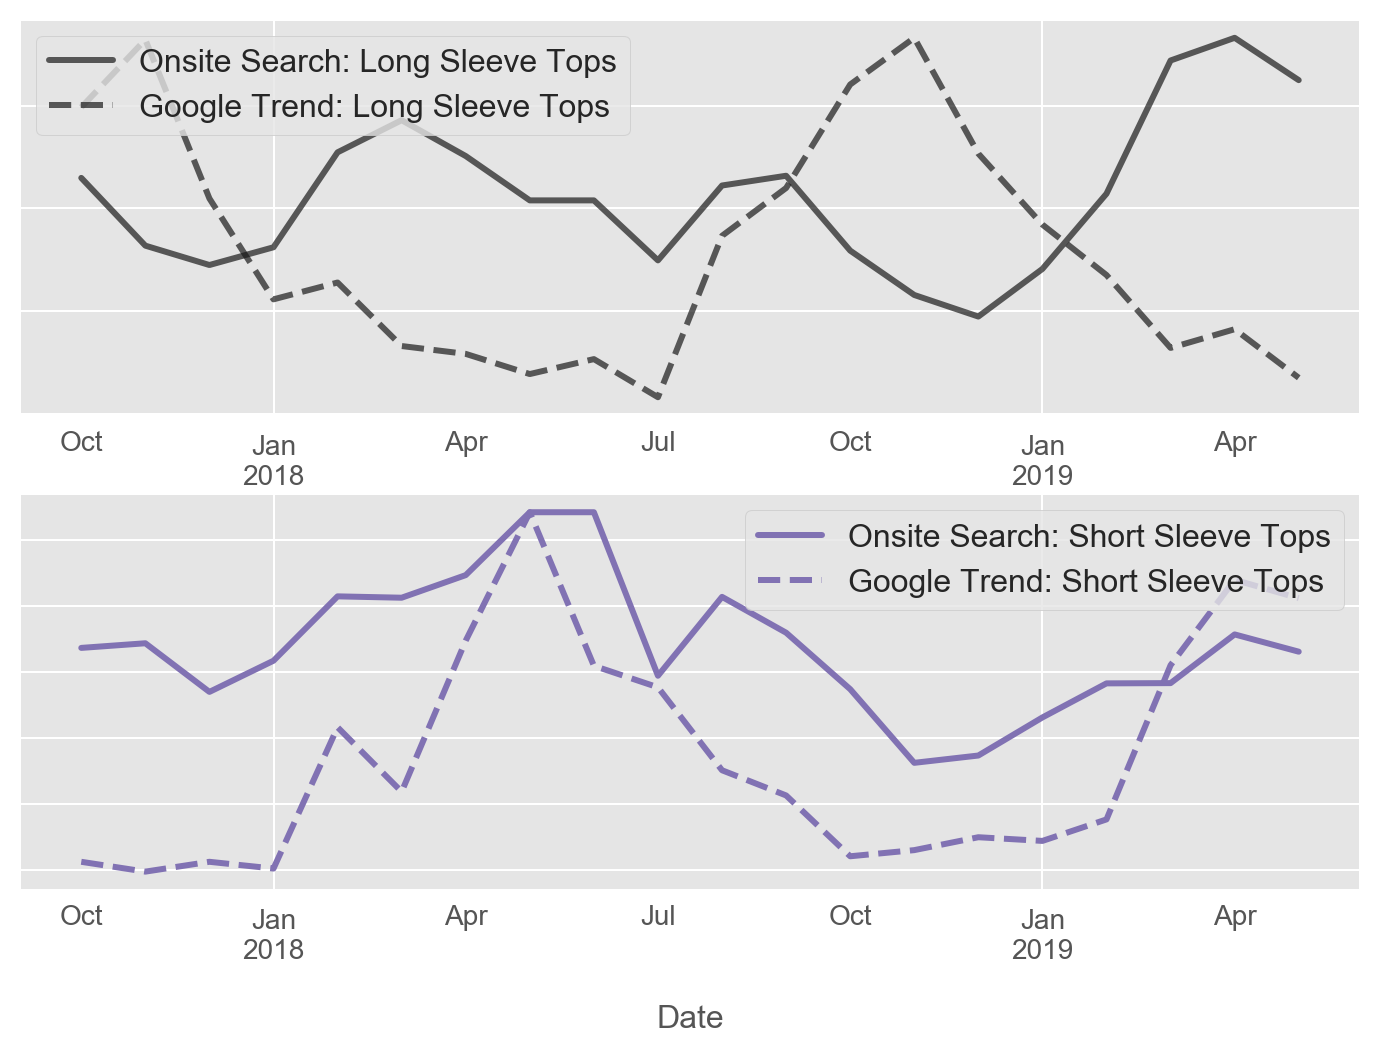

In [244]:
fig, ax = plt.subplots(2)

topic = 'Long Sleeve Tops'
label = 'Onsite Search: {}'.format(topic)
google_trend_col = 'Google Trend: {}'.format(topic)
(df_merge[df_merge.topic == topic].set_index('date')
    [['num_searches', google_trend_col]]
    .fillna(method='pad').rename(columns={'num_searches': label})
    .plot(style=['k-', 'k--'], lw=3, ax=ax[0], alpha=0.7))

topic = 'Short Sleeve Tops'
label = 'Onsite Search: {}'.format(topic)
google_trend_col = 'Google Trend: {}'.format(topic)
(df_merge[df_merge.topic == topic].set_index('date')
    [['num_searches', google_trend_col]]
    .fillna(method='pad').rename(columns={'num_searches': label})
    .plot(style=['m-', 'm--'], lw=3, ax=ax[1]))

ax[0].set_yticklabels([])
ax[1].set_yticklabels([])

plt.xlabel('Date')
savefig('onsite_search_topic=Sleeve-Tops_google_trends')

In [154]:

from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')
